In [4]:
import numpy as np
import pandas as pd
import pandasql as ps
import pymssql

from scipy import stats
from sklearn.neighbors import KernelDensity

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns

#### Fonctions utiles

In [2]:
from numba import jit
@jit(nopython=True)
def _to_hour_bin(a):
    """   Take a (5, n) array representing minutes duration transaction data. 
    Columns order is : ['dur (s)', 'min_sta','min_end', 'h_sta', 'h_end', 'day']. 
    """

    #create new temp cupy array b to contain minute duration per hour.  
    b = np.zeros((len(a),24))
    for j in range(0,len(a)):
        hours = int((a[j][0]/3600)+(a[j][1]/60))
        if(hours==0): # within same hour
            b[j][a[j][3]] = int(a[j][0]/60)
        elif(hours==1): #you could probably delete this condition.
            b[j][a[j][3]] = 60-a[j][1]
            b[j][a[j][4]] = a[j][2]
        else:
            b[j][a[j][3]] = 60-a[j][1]
            if(hours<24): #all array elements will be all 60 minutes if durationa is over 24 hours
                if(a[j][3]+hours<24):
                    b[j][a[j][3]+1:a[j][3]+hours]=60
                    b[j][a[j][4]] = a[j][2]
                else:
                    b[j][a[j][3]+1:24]=60
                    b[j][0:(a[j][3]+1+hours)%24]=60
                    b[j][a[j][4]] = a[j][2]
                    
    return b

#### Lecture de données

In [3]:
trans_count = pd.read_excel('../Données transactions des terrains du Mont-Royal 2017 à 2022.xlsx', sheet_name='Nombre de transactions')

In [5]:
try:
    trans = pd.read_csv('./input/transactions_2017_2022.csv')
except FileNotFoundError:
    con = pymssql.connect(server='prisqlbiprod01')
    
    with open('./input/Transactions 2017-2021.sql', 'r') as f:
        sql = ''.join(f.readlines())

    trans = pd.read_sql(con=con, sql=sql)
    trans.to_csv('./input/transactions_2017_2022.csv', index=False)

In [6]:
try:
    capa = pd.read_csv('./input/capacite_2017_2022.csv')
    capa.Date = pd.to_datetime(capa.Date)
except FileNotFoundError:
    con = pymssql.connect(server='prisqlbiprod01')

    with open('./input/Capacite_2017-2022.sql', 'r') as f:
        sql = ''.join(f.readlines())

    trans = pd.read_sql(con=con, sql=sql)
    trans.to_csv('./input/capacite_2017_2022.csv', index=False)

trans.Fin = pd.to_datetime(trans.Fin)
trans.Debut = pd.to_datetime(trans.Debut)
trans['Durée'] = (trans.Fin - trans.Debut).dt.seconds / 3600
trans['Période'] = ['Fin de semaine' if x in [5,6] else 'Semaine' for x in trans.Debut.dt.day_of_week]
trans['Période_Journée'] = pd.cut(trans.Debut.dt.hour, bins=[0, 5, 7, 19, 24], labels=['00:00 à 06:00', '06:00 à 08:00', '08:00 à 20:00', '20:00 à 23:59'])
trans['Hr_Debut'] = trans.Debut.dt.hour
trans['Hr_Fin'] = trans.Fin.dt.hour
trans['Date'] = trans.Debut.dt.date

In [7]:
sondage = pd.read_excel('./../../34_Rapports/Observateur - Données qualitatives 2022/Nettoyage des données/test.xlsx')

In [8]:
comptages = pd.read_csv('./input/correction_nb_transactions.csv')
comptages['hr_deb'] = comptages.Heure.str[:2].astype(int)
comptages['hr_fin'] = comptages.Heure.str[-5:-3].astype(int)

#### Comparaison temps de stationnement : Transaction - Sondage

In [9]:
sondage.DATE = pd.to_datetime(sondage.DATE).dt.date
date_sondage = list(sondage.DATE.unique())

In [10]:
jour_heure_sondage = (sondage.groupby('DATE')['HEURE'].agg(['min', 'max'])//100).reset_index()

In [11]:
packed = list(zip(jour_heure_sondage['min'], jour_heure_sondage['max'], jour_heure_sondage.DATE))
trs_idx = [idx for el, dt, idx in zip(trans.Hr_Debut, trans.Date, trans.index) for strt, end, ev in packed if strt <= el <= end and ev == dt]

In [37]:
trans_filtered = trans.loc[trs_idx].copy()

In [13]:
sqlcode = '''
select *
from trans
inner join jour_heure_sondage on jour_heure_sondage.DATE=trans.Date
where trans.Hr_Debut >= jour_heure_sondage.min and trans.Hr_Debut <= jour_heure_sondage.max
'''

trans_filtered = ps.sqldf(sqlcode,locals())

In [38]:
trans_filtered['Durée de la visite'] = pd.cut(trans_filtered.Durée, bins=[0,0.999, 1.999, 3.999, 24], labels=['Moins d\'une heure', 'Entre 1h et 2h', 'Entre 2h et 4h', 'Plus de 4h'])

##### Figures

In [39]:
temps_stat_trans = (trans_filtered.pivot_table(index='Durée de la visite', columns='Période', aggfunc='size')/trans_filtered.shape[0]*100).round(2)
temps_stat_trans_15min = (trans_filtered[trans_filtered.Durée * 3600 > 15*60].pivot_table(index='Durée de la visite', columns='Période', aggfunc='size')/trans_filtered[trans_filtered.Durée * 3600 > 15*60].shape[0]*100).round(2)
temps_stat_sondage_depart = (sondage[sondage.CONTEXTE == 2].pivot_table(index='Durée de la visite', columns='Période', aggfunc='size')/sondage[sondage.CONTEXTE == 2].shape[0]*100).round(2)
temps_stat_sondage_arrivee = (sondage[sondage.CONTEXTE == 1].pivot_table(index='Durée de la visite', columns='Période', aggfunc='size')/sondage[sondage.CONTEXTE == 1].shape[0]*100).round(2)

In [40]:
temps_stat_trans           = trans_filtered.pivot_table(index='Durée de la visite', columns='Période', aggfunc='size')
temps_stat_trans_15min     = trans_filtered[trans_filtered.Durée * 3600 > 15*60].pivot_table(index='Durée de la visite', columns='Période', aggfunc='size')
temps_stat_sondage_depart  = sondage[sondage.CONTEXTE == 2].pivot_table(index='Durée de la visite', columns='Période', aggfunc='size')
temps_stat_sondage_arrivee = sondage[sondage.CONTEXTE == 1].pivot_table(index='Durée de la visite', columns='Période', aggfunc='size')

In [41]:
temps_stat_trans['Intrant']           = 'Transactions'
temps_stat_trans_15min['Intrant']     = 'Transactions >= 15min'
temps_stat_sondage_depart['Intrant']  = 'Sondage - Départ'
temps_stat_sondage_arrivee['Intrant'] = 'Sondage - Arrivée'

In [42]:
temps_stat_trans['Total']           = temps_stat_trans.Semaine + temps_stat_trans['Fin de semaine']
temps_stat_trans_15min['Total']     = temps_stat_trans_15min.Semaine + temps_stat_trans_15min['Fin de semaine']
temps_stat_sondage_depart['Total']  = temps_stat_sondage_depart.Semaine + temps_stat_sondage_depart['Fin de semaine']
temps_stat_sondage_arrivee['Total'] = temps_stat_sondage_arrivee.Semaine + temps_stat_sondage_arrivee['Fin de semaine']

In [43]:
temps_stat_trans           = temps_stat_trans.reset_index().set_index(['Intrant','Durée de la visite'])
temps_stat_trans_15min     = temps_stat_trans_15min.reset_index().set_index(['Intrant','Durée de la visite'])
temps_stat_sondage_depart  = temps_stat_sondage_depart.reset_index().set_index(['Intrant','Durée de la visite'])
temps_stat_sondage_arrivee = temps_stat_sondage_arrivee.reset_index().set_index(['Intrant','Durée de la visite'])

In [44]:
count_total = pd.concat([temps_stat_trans, temps_stat_trans_15min, temps_stat_sondage_depart, temps_stat_sondage_arrivee])

In [45]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('figs/temps de stationnement/données_v2.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
temps_stat_trans.to_excel(writer, sheet_name='Transactions')
temps_stat_trans_15min.to_excel(writer, sheet_name='Transactions - 15min filtrées')
temps_stat_sondage_depart.to_excel(writer, sheet_name='Sondage - Départ')
temps_stat_sondage_arrivee.to_excel(writer, sheet_name='Sondage - Arrivée')
temps_stat_sondage_arrivee.to_excel(writer, sheet_name='Comptage - Tous')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

C:\Users\alaurent\AppData\Local\Temp\ipykernel_33972\306496367.py:12: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


In [49]:
trans_filtered.columns

Index(['No_Terrain', 'Debut', 'Fin', 'Durée', 'Période', 'Période_Journée',
       'Hr_Debut', 'Hr_Fin', 'Date', 'Durée de la visite'],
      dtype='object')

In [51]:
# Temps de stationnement - Transactions
sns.histplot(data=trans_filtered, x="Durée de la visite", hue="Période", multiple="dodge", shrink=.8, stat="percent")
ax = plt.gca()
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Pourcentage')
f = plt.gcf()
f.savefig('./figs/temps de stationnement/Temps de stationnement - Transactions.png', bbox_inches='tight')
plt.clf()

# Temps de stationnement - Transactions - Sans les 15min et moins
sns.histplot(data=trans_filtered[trans_filtered.Durée * 3600 > 15*60], x="Durée de la visite", hue="Période", multiple="dodge", shrink=.8, stat="percent")
ax = plt.gca()
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Pourcentage')
f = plt.gcf()
f.savefig('./figs/temps de stationnement/Temps de stationnement - Transactions - filtrées.png', bbox_inches='tight')
plt.clf()

# Temps de stationnement - Sondage - DEPART
sondage['Durée de la visite'] = pd.Categorical(sondage['Durée de la visite'], ['Moins d\'une heure', 'Entre 1h et 2h', 'Entre 2h et 4h', 'Plus de 4h'])
sns.histplot(data=sondage[sondage.CONTEXTE==2], x='Durée de la visite', hue='Période', multiple="dodge", shrink=.8, stat="percent")
ax = plt.gca()
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Pourcentage')
f = plt.gcf()
f.savefig('./figs/temps de stationnement/Temps de stationnement - Sondage - Départ.png', bbox_inches='tight')
plt.clf()

# Temps de stationnement - Sondage - ARRIVEE
sondage['Durée de la visite'] = pd.Categorical(sondage['Durée de la visite'], ['Moins d\'une heure', 'Entre 1h et 2h', 'Entre 2h et 4h', 'Plus de 4h'])
sns.histplot(data=sondage[sondage.CONTEXTE==1], x='Durée de la visite', hue='Période', multiple="dodge", shrink=.8, stat="percent")
ax = plt.gca()
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Pourcentage')
f = plt.gcf()
f.savefig('./figs/temps de stationnement/Temps de stationnement - Sondage - Arrivée.png', bbox_inches='tight')
plt.clf()

<Figure size 640x480 with 0 Axes>

#### Génération de transactions par tranches horraires

In [52]:
ANNEE = [2017]#, 2018, 2019, 2022]
TERRAINS = [115, 116, 117, 118]#[116, 117]#
SEED = 115
np.random.seed(SEED)

Filtrage des transactions et capacitées d'intérêts

In [53]:
filtered_capa = capa[(capa.Date.dt.year.isin(ANNEE)) & (capa.No_Terrain.isin(TERRAINS))].copy()
filtered_capa = filtered_capa.groupby('Date')[['Nb_Place']].sum()

In [104]:
## Apply corrections of transactions counts per hour from survey
filtered_count = trans_count[(trans_count.year.isin(ANNEE)) & (trans_count.id_terrain.isin(TERRAINS))].copy()
filtered_count.period = filtered_count.period.map({'week-end':'Fin de semaine', 'week-day':'Semaine'})

# join
packed = list(zip(comptages['hr_deb'], comptages['hr_fin'], comptages.correction, comptages.periode))
trsf_idx = [[idx, cor] for el, dt, idx in zip(filtered_count.hour, filtered_count.period, filtered_count.index) for strt, end, cor, ev in packed if strt <= el < end and ev == dt]
filtered_count = filtered_count.loc[np.array(trsf_idx)[:,0]]
filtered_count['correction'] = np.array(trsf_idx)[:,1]

filtered_count['transactions_count_corrected'] = filtered_count.transactions_count * (1+filtered_count.correction)

## get the count of transaction for each hour for year ANNEE from all TERRAINS
#filtered_count = filtered_count[filtered_count.hour >= 6].groupby(['year', 'month', 'day', 'hour'])[['transactions_count', 'transactions_count_corrected']].sum()
filtered_count = filtered_count.groupby(['year', 'month', 'day', 'hour'])[['transactions_count', 'transactions_count_corrected']].sum()

In [100]:
## Apply corrections of transactions counts per hour from survey
#filtered_count = trans_count[(trans_count.year.isin(ANNEE)) & (trans_count.id_terrain.isin(TERRAINS))].copy()
#filtered_count.period = filtered_count.period.map({'week-end':'Fin de semaine', 'week-day':'Semaine'})
#
#sqlcode = '''
#select *
#from filtered_count
#inner join comptages on comptages.periode=filtered_count.period
#where filtered_count.hour >= comptages.hr_deb and filtered_count.hour < comptages.hr_fin
#'''
#filtered_count = ps.sqldf(sqlcode,locals())
#
#filtered_count.drop(columns=['periode'], inplace=True)
#filtered_count['transactions_count_corrected'] = filtered_count.transactions_count * (1+filtered_count.correction)
#
### get the count of transaction for each hour for year ANNEE from all TERRAINS
##filtered_count = filtered_count[filtered_count.hour >= 6].groupby(['year', 'month', 'day', 'hour'])[['transactions_count', 'transactions_count_corrected']].sum()
#filtered_count = filtered_count.groupby(['year', 'month', 'day', 'hour'])[['transactions_count', 'transactions_count_corrected']].sum()

In [105]:
fc = filtered_count.reset_index().copy()
fc.groupby('year')[['transactions_count', 'transactions_count_corrected']].sum().astype(int)

,transactions_count,transactions_count_corrected
year,,
2017,304625,427185


In [106]:
filtered_count.to_csv('Nombre de transactions_[2017].csv')

Génération de transactions à partir de la Gaussienne du temps de visite dérivée du sondage

In [107]:
# Idx for stayed time
temps_stat = sondage[sondage.CONTEXTE == 2].copy()
map_heure = {
    'Moins d\'une heure'    :0,
    'Entre 1h et 2h'        :1,
    'Entre 2h et 4h'        :2,
    'Plus de 4h'            :3,
}
distrib_temps_stat = temps_stat['Durée de la visite'].map(map_heure).astype(int).values
temps_height = [1, 1, 2, 3]
temps_decalage = [1, 2, 3, 5]

# generate KDE stationnement
kde = KernelDensity(bandwidth=0.1).fit(distrib_temps_stat.reshape(-1, 1))

# generation of transaction for each day/hour
res = []
for idx, data in filtered_count.iterrows():
    nb_trans = int(data.transactions_count_corrected)
    idx_ts = kde.sample(nb_trans).round(0).astype(int).ravel()
    times =( np.random.randint([temps_height[j] for j in idx_ts]) + [temps_decalage[j] for j in idx_ts] ).reshape((idx_ts.shape[0]), 1)
    generated_data = np.concatenate((np.broadcast_to(np.array(idx), (times.shape[0],len(idx))), times), axis=1)
    res.append(generated_data)

generated_trans = pd.DataFrame(np.concatenate(res), columns=['year', 'month', 'day', 'hour', 'stay_duration_h'])
generated_trans['hr_start'] = generated_trans.hour.copy()
generated_trans['hr_end'] = (generated_trans.hour.copy() + generated_trans.stay_duration_h.copy()).clip(0, 24)

In [108]:
print("Pourcentage de transactions ajoutées :", np.round((1 - trans[(trans.Debut.dt.year.isin(ANNEE)) & trans.No_Terrain.isin(TERRAINS)].shape[0] / generated_trans.shape[0]) * 100, 2))

Pourcentage de transactions ajoutées : 28.08


Calcul de l'espace occupée et du taux d'occupation par jour/heure

In [109]:
# Shaping a DataFrame to pass to fucntion _to_hour_bin
df = pd.DataFrame()
df['dur'] = generated_trans.stay_duration_h * 3600
df['min_sta'] = 0
df['min_end'] = 0
df['h_sta'] = generated_trans.hr_start
df['h_end'] = generated_trans.hr_end
df['day'] = generated_trans.day
## transform 24:00 to 23:59
df.loc[df.h_end == 24, 'min_end'] = 59
df.loc[df.h_end == 24, 'h_end'] = 23
## recompute duration
df['dur'] = (df.h_end * 3600 + df.min_end * 60) - (df.h_sta * 3600 + df.min_sta * 60)

# Minutes stayed by hour
tranformed_generated_trans = df.to_numpy().astype(int)
tranformed_generated_trans = _to_hour_bin(tranformed_generated_trans)

#concat the original and hour_bin df
hours_col = np.arange(0, 24, 1).astype(str)
cpdf = pd.DataFrame(tranformed_generated_trans, columns=hours_col)
generated_trans = pd.concat([generated_trans, cpdf], axis=1)

In [110]:
# compute nb place used
generated_trans = generated_trans.groupby(['year', 'month', 'day'])[hours_col].sum()/60 # divide by 60 as we're in minutes
generated_trans['23'] = np.ceil(generated_trans['23'])
# shift database to more readable format
generated_trans = generated_trans.reset_index().melt(id_vars=['year', 'month', 'day'], var_name='hour', value_name='occupied_space')
generated_trans.hour = generated_trans.hour.astype(int)
# get capacity for the parking 
generated_trans['date'] = generated_trans[['year', 'month', 'day']].apply(lambda x:pd.to_datetime(f'{int(x.year)}-{int(x.month)}-{int(x.day)}').date(), axis=1)
generated_trans.date = pd.to_datetime(generated_trans.date)
generated_trans = generated_trans.join(filtered_capa, on='date', how='left').rename(columns={'Nb_Place':'capa'})
# compute occupancy
generated_trans['occup'] = np.round((generated_trans.occupied_space / generated_trans.capa)*100, 2)
# save data
generated_trans.sort_values(['year', 'month', 'day', 'hour']).drop(columns='date').to_excel(f'./Transactions_générées_{ANNEE}_v1.xlsx', index=False)

#### Analyse dépassement

##### Takeaway

Scénario 85%

In [111]:
depacement = np.count_nonzero(generated_trans.groupby('date')[['occup']].max() > 85)
depacement_prc = np.round(( np.count_nonzero(generated_trans.groupby('date')[['occup']].max() > 85) / generated_trans.groupby('date').size().shape[0] ) * 100, 2)

In [112]:
print(f"Sur l'année {ANNEE}, pour les terrains {TERRAINS[0] if len(TERRAINS) <= 2 else ', '.join([t.__str__() for t in TERRAINS[:-1]])}{' et ' + TERRAINS[-1].__str__() if len(TERRAINS) > 1 else ''}, on prédit un dépacement de {depacement} jours soit {depacement_prc}% de l'année")

Sur l'année [2017], pour les terrains 115, 116, 117 et 118, on prédit un dépacement de 55 jours soit 15.07% de l'année


Scénario 100%

In [113]:
depacement = np.count_nonzero(generated_trans.groupby('date')[['occup']].max() > 100)
depacement_prc = np.round(( np.count_nonzero(generated_trans.groupby('date')[['occup']].max() > 100) / generated_trans.groupby('date').size().shape[0] ) * 100, 2)

In [114]:
print(f"Sur l'année {ANNEE}, pour les terrains {TERRAINS[0] if len(TERRAINS) <= 2 else ', '.join([t.__str__() for t in TERRAINS[:-1]])}{' et ' + TERRAINS[-1].__str__() if len(TERRAINS) > 1 else ''}, on prédit un dépacement de {depacement} jours soit {depacement_prc}% de l'année")

Sur l'année [2017], pour les terrains 115, 116, 117 et 118, on prédit un dépacement de 31 jours soit 8.49% de l'année


Journée ou l'on dépasse

In [115]:
depassement_100_date = generated_trans.groupby('date')[['hour','occup']].max()[generated_trans.groupby('date')['occup'].max() > 100].reset_index()
depassement_100_date['periode'] = ['week-end' if x in [5,6] else 'week-day' for x in depassement_100_date.date.dt.day_of_week]

##### Figures

Occupation

In [116]:
max_occup = generated_trans.groupby('date')[['occupied_space', 'occup']].max().reset_index()
max_occup['day_of_year'] = max_occup.date.dt.day_of_year
max_occup['Période'] = ['Fin de semaine' if x in [5,6] else 'Semaine' for x in max_occup.date.dt.day_of_week]

In [117]:
palette = {'Semaine': '#AAE0FA', 'Fin de semaine': '#0083C5'}

In [118]:
months_label = max_occup.date.dt.month.diff()
months_label.loc[0] = 1
months_label.loc[months_label == 1] = ['Jan', 'Fev', 'Mar', 'Avr', 'Mai', 'Jun', 'Jui', 'Aou', 'Sep', 'Oct', 'Nov', 'Dec']
months_label = months_label.replace(0, '').values

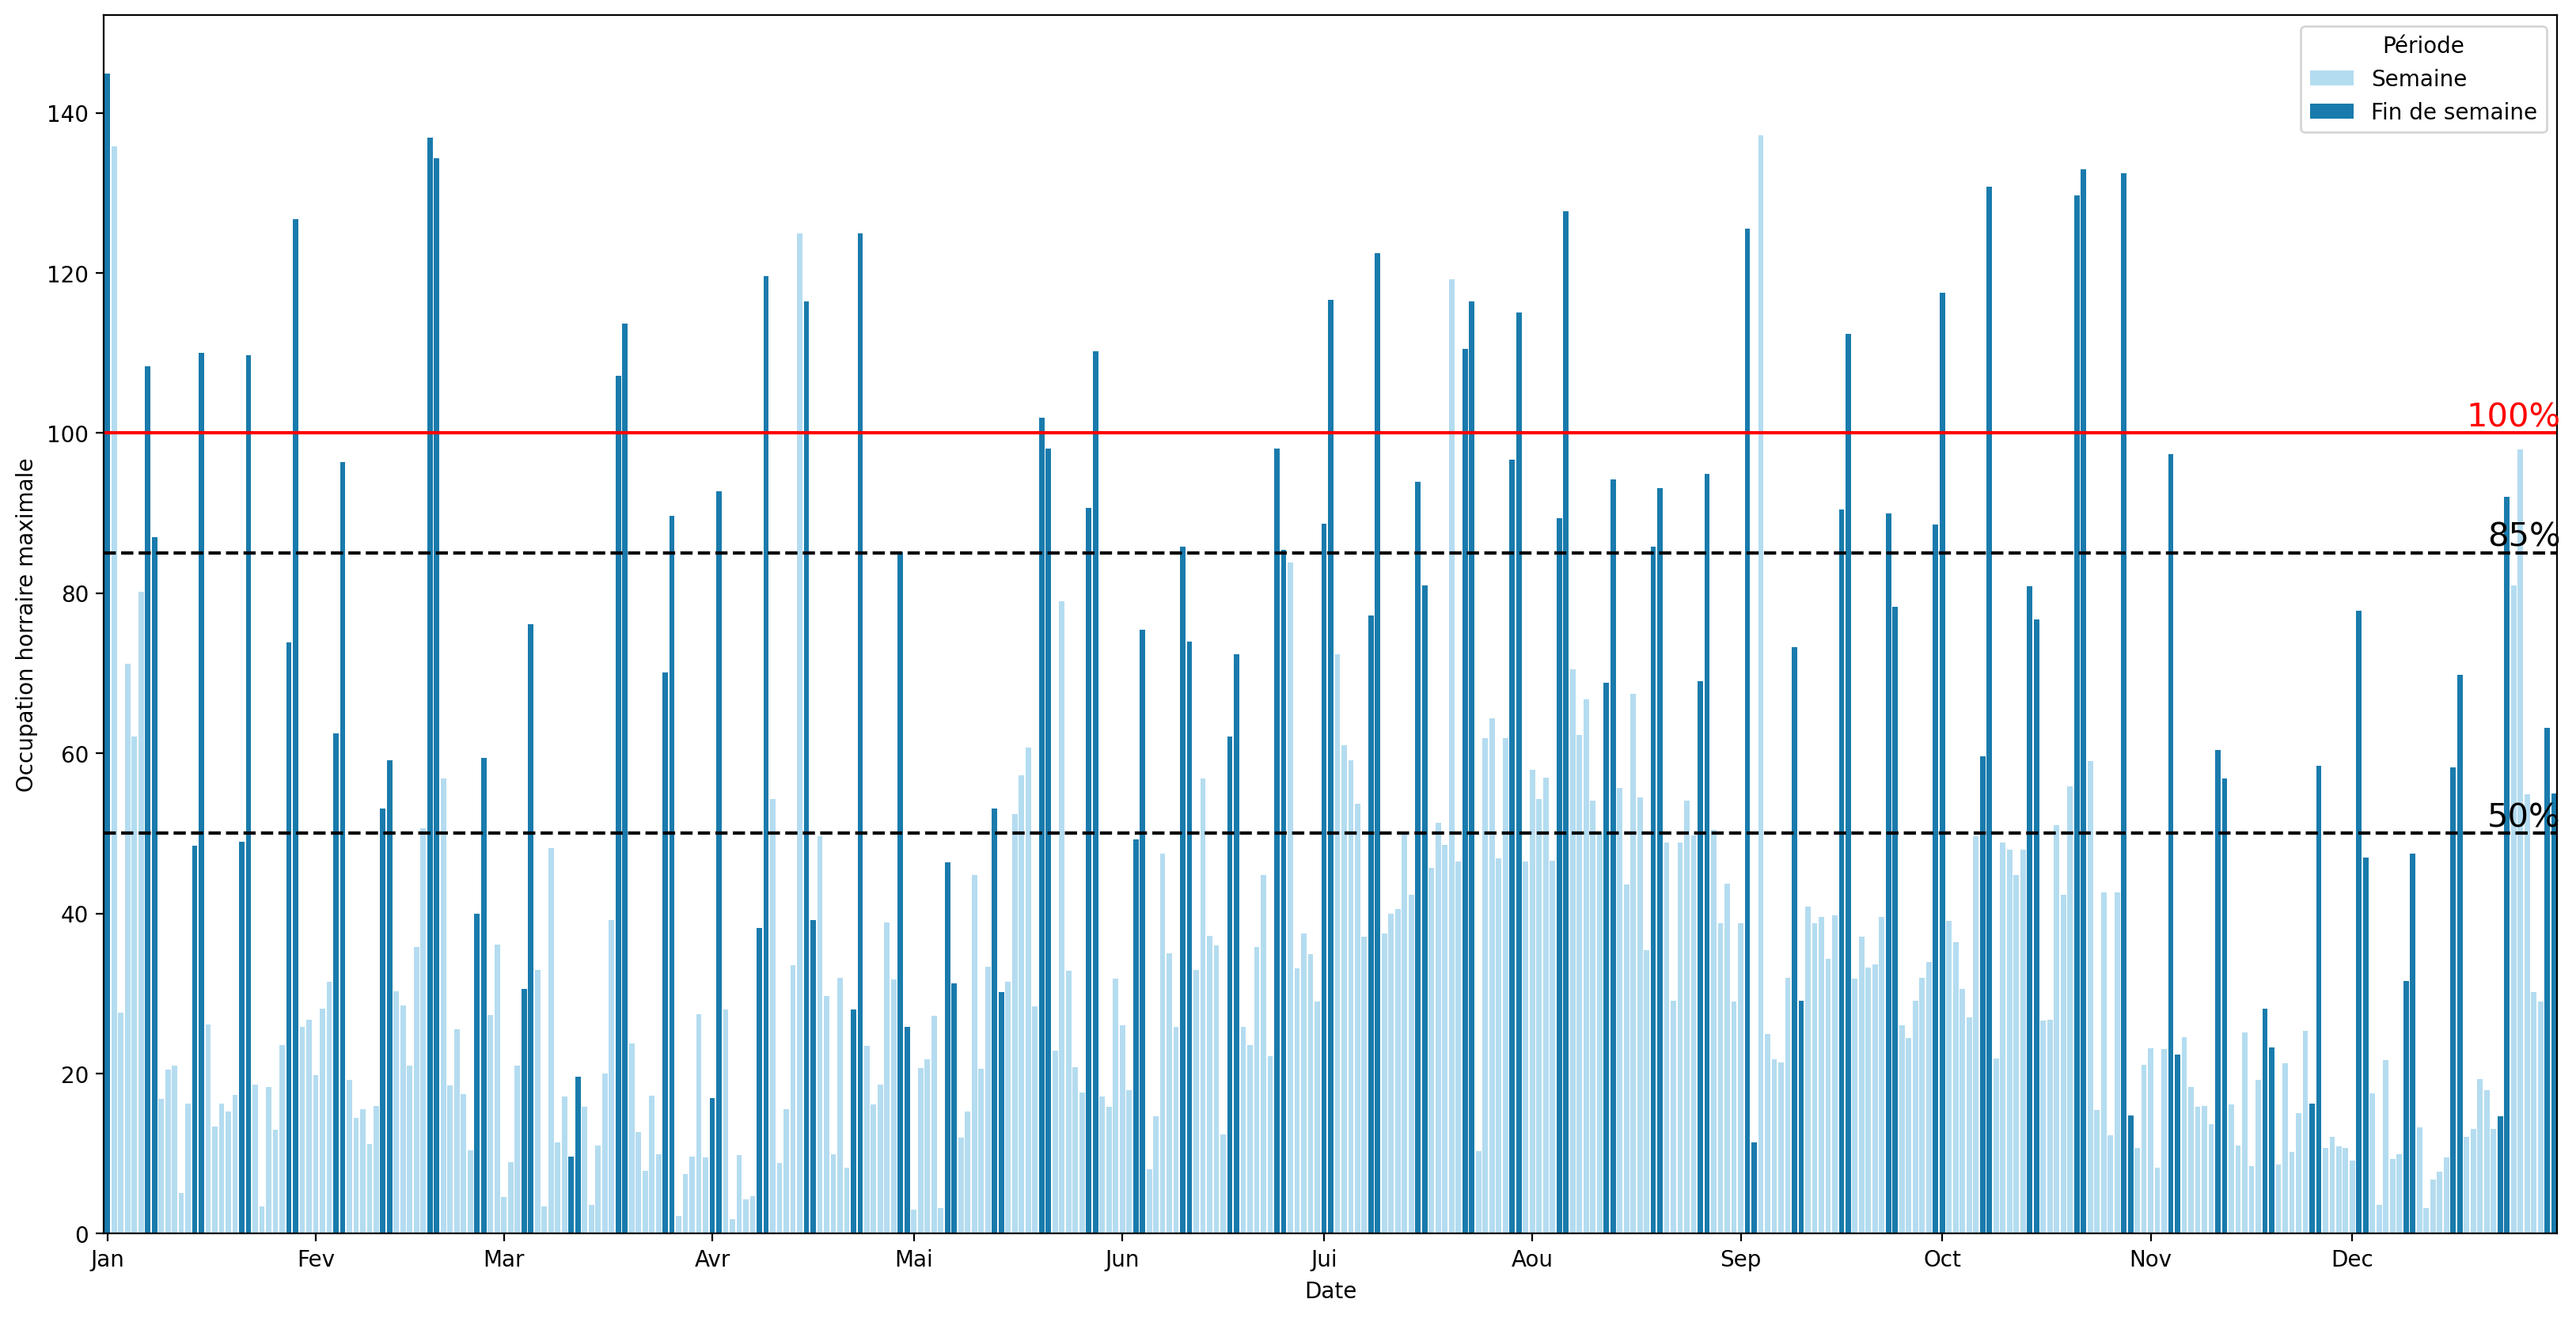

In [119]:
f, ax = plt.subplots(figsize=(20, 10), dpi=200);
sns.barplot(data=max_occup, x='day_of_year', y='occup', hue='Période', hue_order=['Semaine', 'Fin de semaine'], palette=palette, dodge=False)
# 100%
plt.axhline(y=100, color='r', linestyle='-');
t = plt.text(365, 100, f'100%', fontsize=15, color='r', va='bottom', ha='right', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))
# 85%
plt.axhline(y=85, color='k', linestyle='--');
t = plt.text(365, 85, f'85%', fontsize=15, color='k', va='bottom', ha='right', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))
# 50%
plt.axhline(y=50, color='k', linestyle='--');
t = plt.text(365, 50, f'50%', fontsize=15, color='k', va='bottom', ha='right', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))

# ticks
ax.set_xticks(np.argwhere(months_label != '').ravel());
ax.set_xticklabels(['Jan', 'Fev', 'Mar', 'Avr', 'Mai', 'Jun', 'Jui', 'Aou', 'Sep', 'Oct', 'Nov', 'Dec']);
ax.set_xlabel('Date');
ax.set_ylabel('Occupation horraire maximale');
ax.legend(title='Période', loc='upper right');
f.savefig(f'./figs/analyse de dépassement/portrait du dépassement {ANNEE}.png');

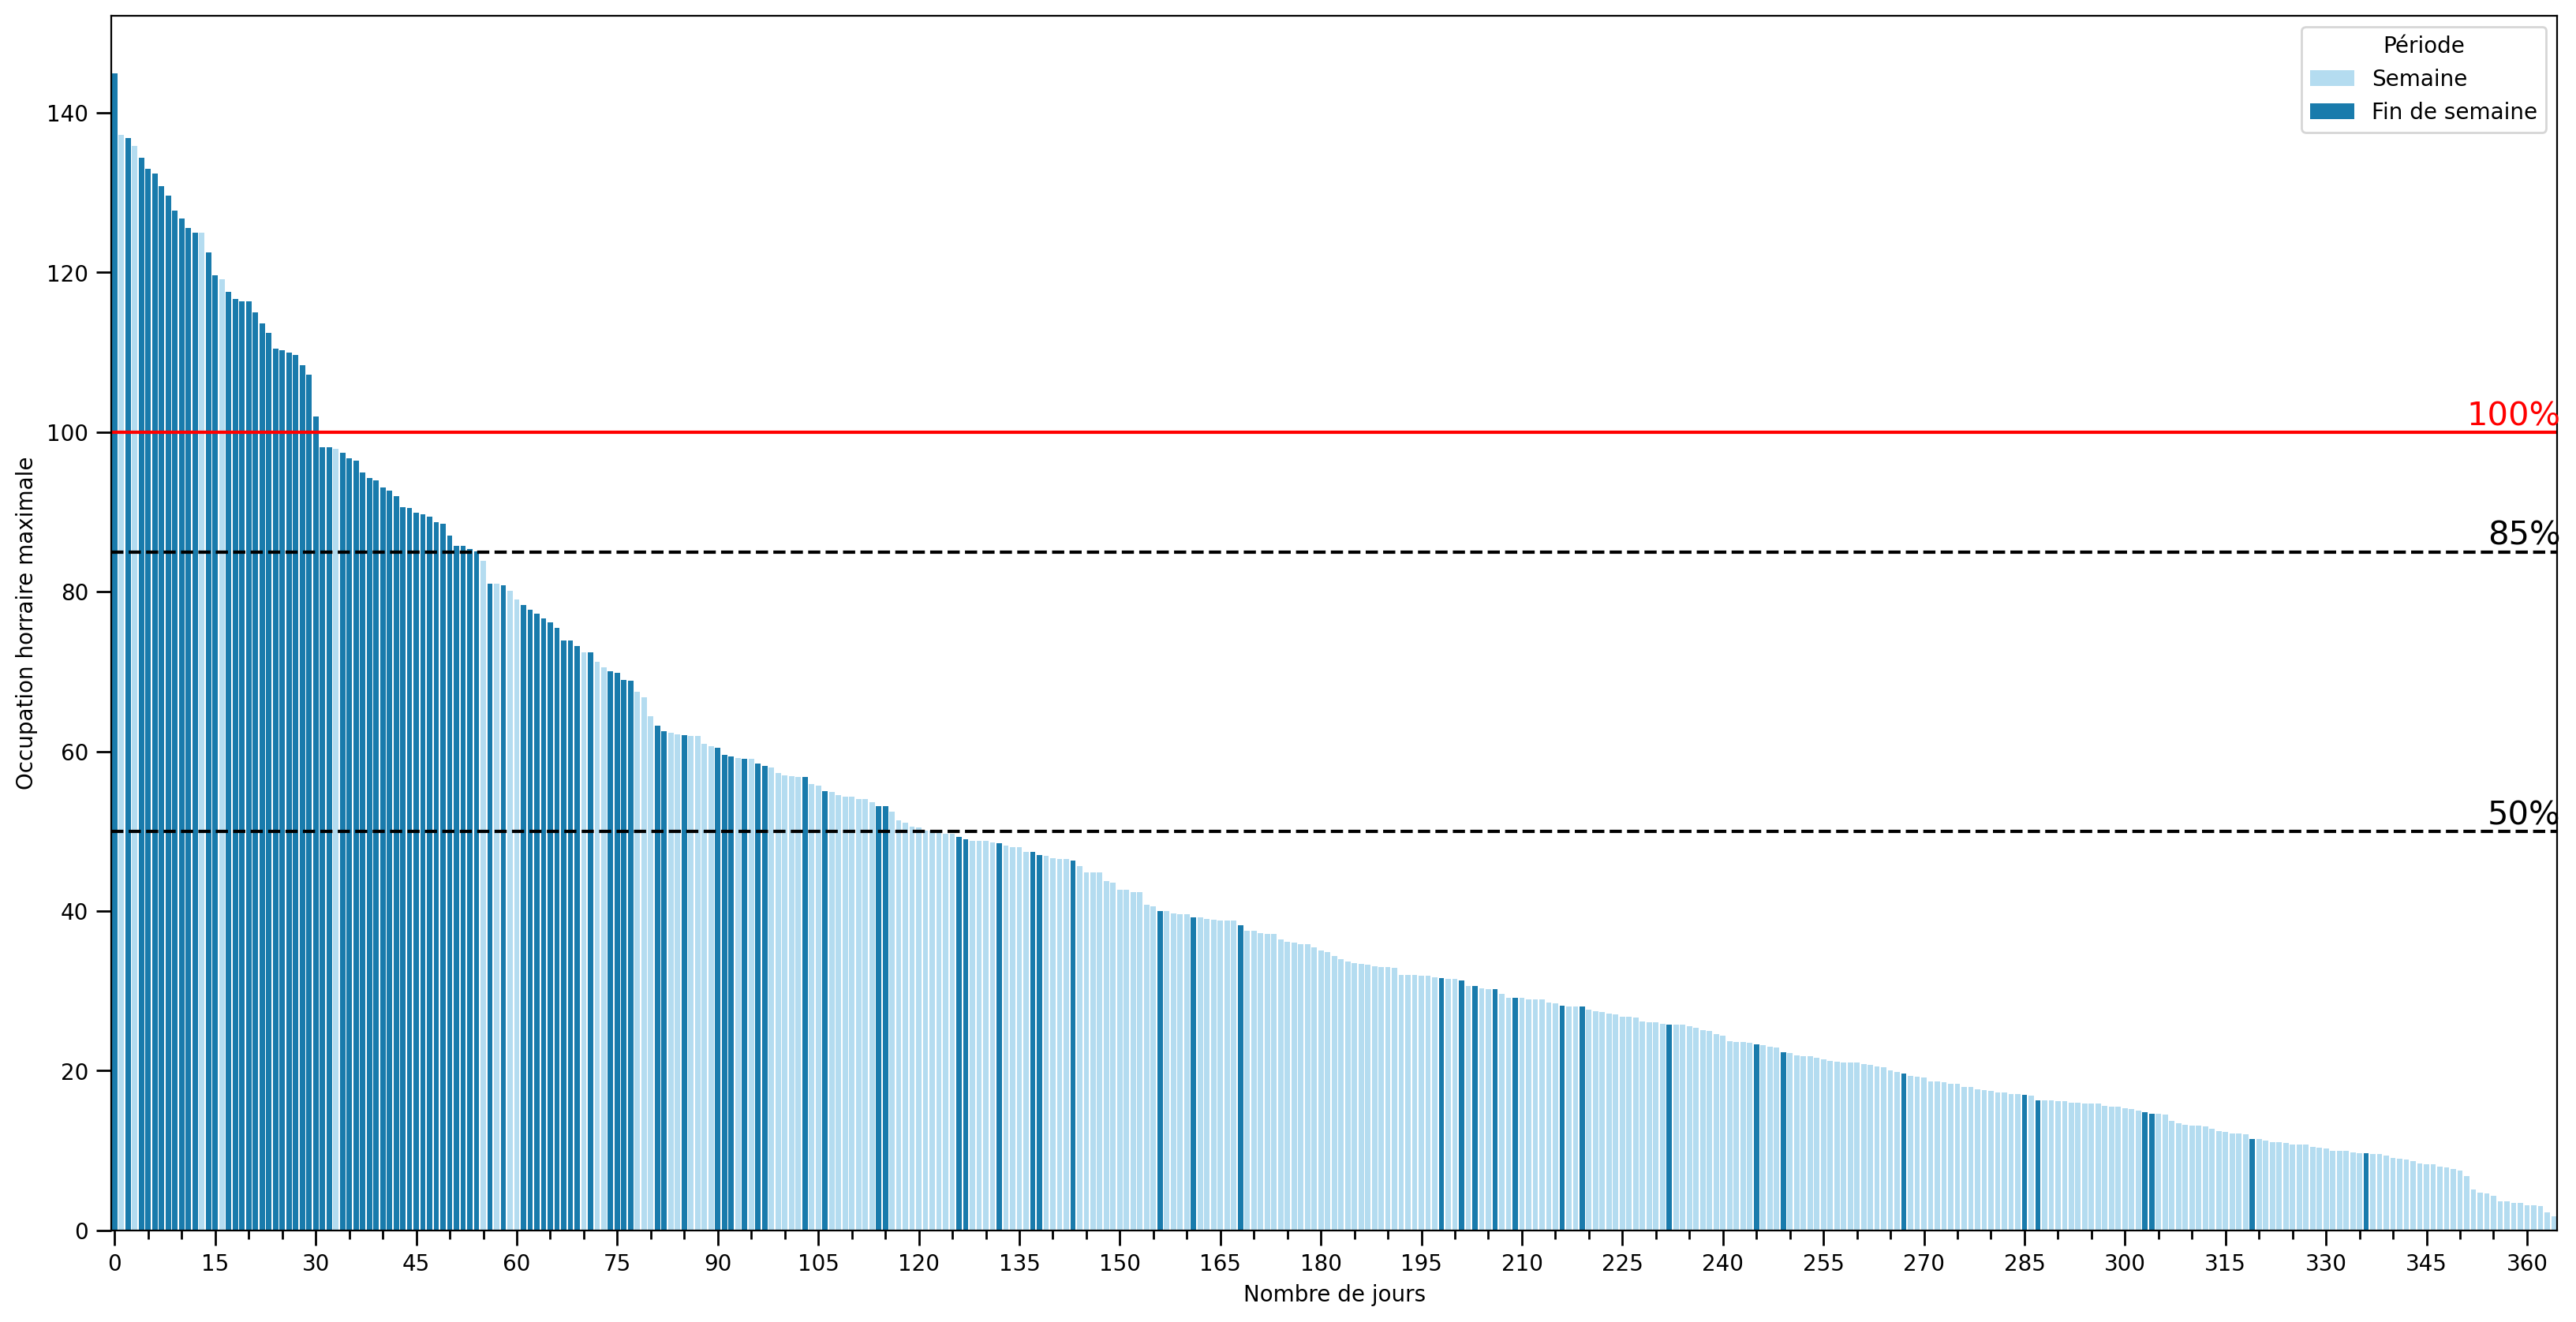

In [120]:
f, ax = plt.subplots(figsize=(20, 10), dpi=200)
sns.barplot(data=max_occup.sort_values('occup', ascending=False).reset_index(drop=True).reset_index(), x='index', y='occup', hue='Période', hue_order=['Semaine', 'Fin de semaine'], palette=palette, dodge=False)
# 100%
plt.axhline(y=100, color='r', linestyle='-');
t = plt.text(365, 100, f'100%', fontsize=15, color='r', va='bottom', ha='right', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))
# 85%
plt.axhline(y=85, color='k', linestyle='--');
t = plt.text(365, 85, f'85%', fontsize=15, color='k', va='bottom', ha='right', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))
# 50%
plt.axhline(y=50, color='k', linestyle='--');
t = plt.text(365, 50, f'50%', fontsize=15, color='k', va='bottom', ha='right', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))

# ticks
ax.xaxis.set_major_locator(MultipleLocator(15))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(5))

ax.tick_params(which='both', width=1)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)

ax.set_xlabel('Nombre de jours')
ax.set_ylabel('Occupation horraire maximale');
ax.legend(title='Période', loc='upper right')
#f.savefig(f'./figs/analyse de dépassement/portrait du dépassement {ANNEE} - occup triée.png')

In [121]:
category_df = []
category_dict = {
    'Contraintes':0.23,
    'Groupe':0.05,
    'Distance':0.32,
    'Autres':0.4
}

for idx, row in max_occup.sort_values('occup', ascending=False).reset_index(drop=True).iterrows():
    for name, prc in category_dict.items():
        row_tmp = row.copy()
        row_tmp['Ordre'] = idx
        row_tmp['Types de déplacements'] = name
        row_tmp['occupied_space'] *= prc
        row_tmp['occup'] *= prc
        category_df.append(row_tmp.values)

In [122]:
data_contraintes = pd.DataFrame(category_df, columns=max_occup.columns.to_list() + ['Ordre', 'Types de déplacements'])

In [123]:
LAPIN_PALETTES = dict(
     PROV_BLUES = lambda n_colors=None, reverse=None, as_cmap=False: sns.dark_palette("#69d", n_colors, reverse, as_cmap),
     PROV_REDS = lambda n_colors=None, desat=None, as_cmap=False: sns.color_palette("flare", n_colors, desat, as_cmap),
     CAPA = lambda n_colors=None, desat=None, as_cmap=False: sns.color_palette("crest", n_colors, desat, as_cmap),
     OCC_BLUES = lambda n_colors=None, desat=None, as_cmap=False: sns.color_palette('Blues', n_colors, desat, as_cmap),
     OCC_REDS = lambda n_colors=None, desat=None, as_cmap=False: sns.color_palette('Reds', n_colors, desat, as_cmap),
     OCC_GREENS = lambda n_colors=None, desat=None, as_cmap=False: sns.color_palette('Greens', n_colors, desat, as_cmap),
     OCC_GNYLRD = lambda n_colors=None, desat=None, as_cmap=False: sns.color_palette('RdYlGn_r', n_colors, desat, as_cmap),
     OCC_VLAG = lambda n_colors=None, desat=None, as_cmap=False: sns.color_palette('coolwarm', n_colors, desat, as_cmap)
)

def plot_stacked_charge_graphs(charges,
                               groupnames,
                               x=None,
                               colormap=None,   #THIS MUST CONTAIN THE EXACT NUMBER OF COLORS!
                               ticklabels=None,
                               title=None,
                               xlabel=None,
                               ylabel=None,
                               ax=None,
                               legend_kwargs=False,
                               return_fig=False,
                               return_handles=False,
                               figsize=(12.65, 9.49),
                               figdpi=150,
                               ):
    """This is a base canevas for plotting "provenance" load graphs.

    These graphs being in need of complicated legend objects, this function is
    only a frame and does not provide the full capabilities found in it's API
    equivalent functions.

    Parameters
    ----------
    charges : 2dlist
        Number of people onboard for evey item in `ticklabels`. The second
        dimension of the 2dlist should be consistent with the dimension of
        `groupnames`.

    groupnames : list of str
        The name of the different surfaces.

    x : 1dlist, optional
        Axes on top of which data is drawn.

        Default : None

    colormap : list of matplotlib.pyplot.colormap or None, optional
        The colors to assign to the surfaces. This should be the same dimension
        as `groupnames`.  If None, uses matplotlib default colorcycle.

        Default : None

    ticklabels : list of str or None, optional
        The stop labels to assign on the x-axis of the plot. If None, the default
        matplotlib ticklabels are left intact, which means ``range(len(charges[0]))``.

        Default : None

    title : str or None, optional
        The graph title.
        Default : None

    legend_kwargs : dict or None, optional
        If a dict is provided, triggers the creation of a legend via matplotlib.pyplot.legend
        using the options provided. An empty dict will use the default matplotlib
        settings for a legend

        Default : False

    return_fig : bool, optional
        If True, the returned tuple starts with a figure maplotlib.pyplot.figure
        object. (ie: fig, ax, ...)
        Default : False

    return_handles : bool, optional
        If true, the returned tuple ends with a maplotlib.pyplot.PolyCollection
        objects containing handles to the surfaces of the stackplot.
        (ie: ..., ax, handles)

        Default : False
    Returns
    -------
    ax : maplotlib.pyplot.axes.Axes

    """
    #produce the fig

    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=figsize, dpi=figdpi)

        if x is not None:
            handle = ax.stackplot(x, charges, labels=groupnames, colors=colormap)
        else:
            handle = ax.stackplot(range(len(charges[0])), *charges, labels=groupnames, colors=colormap)

        if xlabel is not None:
            ax.set_xlabel(xlabel, size=14)

        if ylabel is not None:
            ax.set_ylabel(ylabel, size=14)

        if title is not None:
            ax.set_title(title, size=14)

        if ticklabels is not None:
            ax.set_xticks(range(len(ticklabels)))
            ax.set_xticklabels(ticklabels, rotation=90, ha='center')

        if legend_kwargs is not None:
            ax.legend(**legend_kwargs)

        #ax.grid(color='grey', linestyle='dashed')
        ax.set_axisbelow(True)

    out=[]
    if return_fig:
        out.append(fig)
    out.append(ax)
    if return_handles:
        out.append(handle)

    return out

In [124]:
groupnames = list(category_dict.keys())
charges = data_contraintes.pivot_table(index='Ordre', columns='Types de déplacements', values='occup')[groupnames].values.T

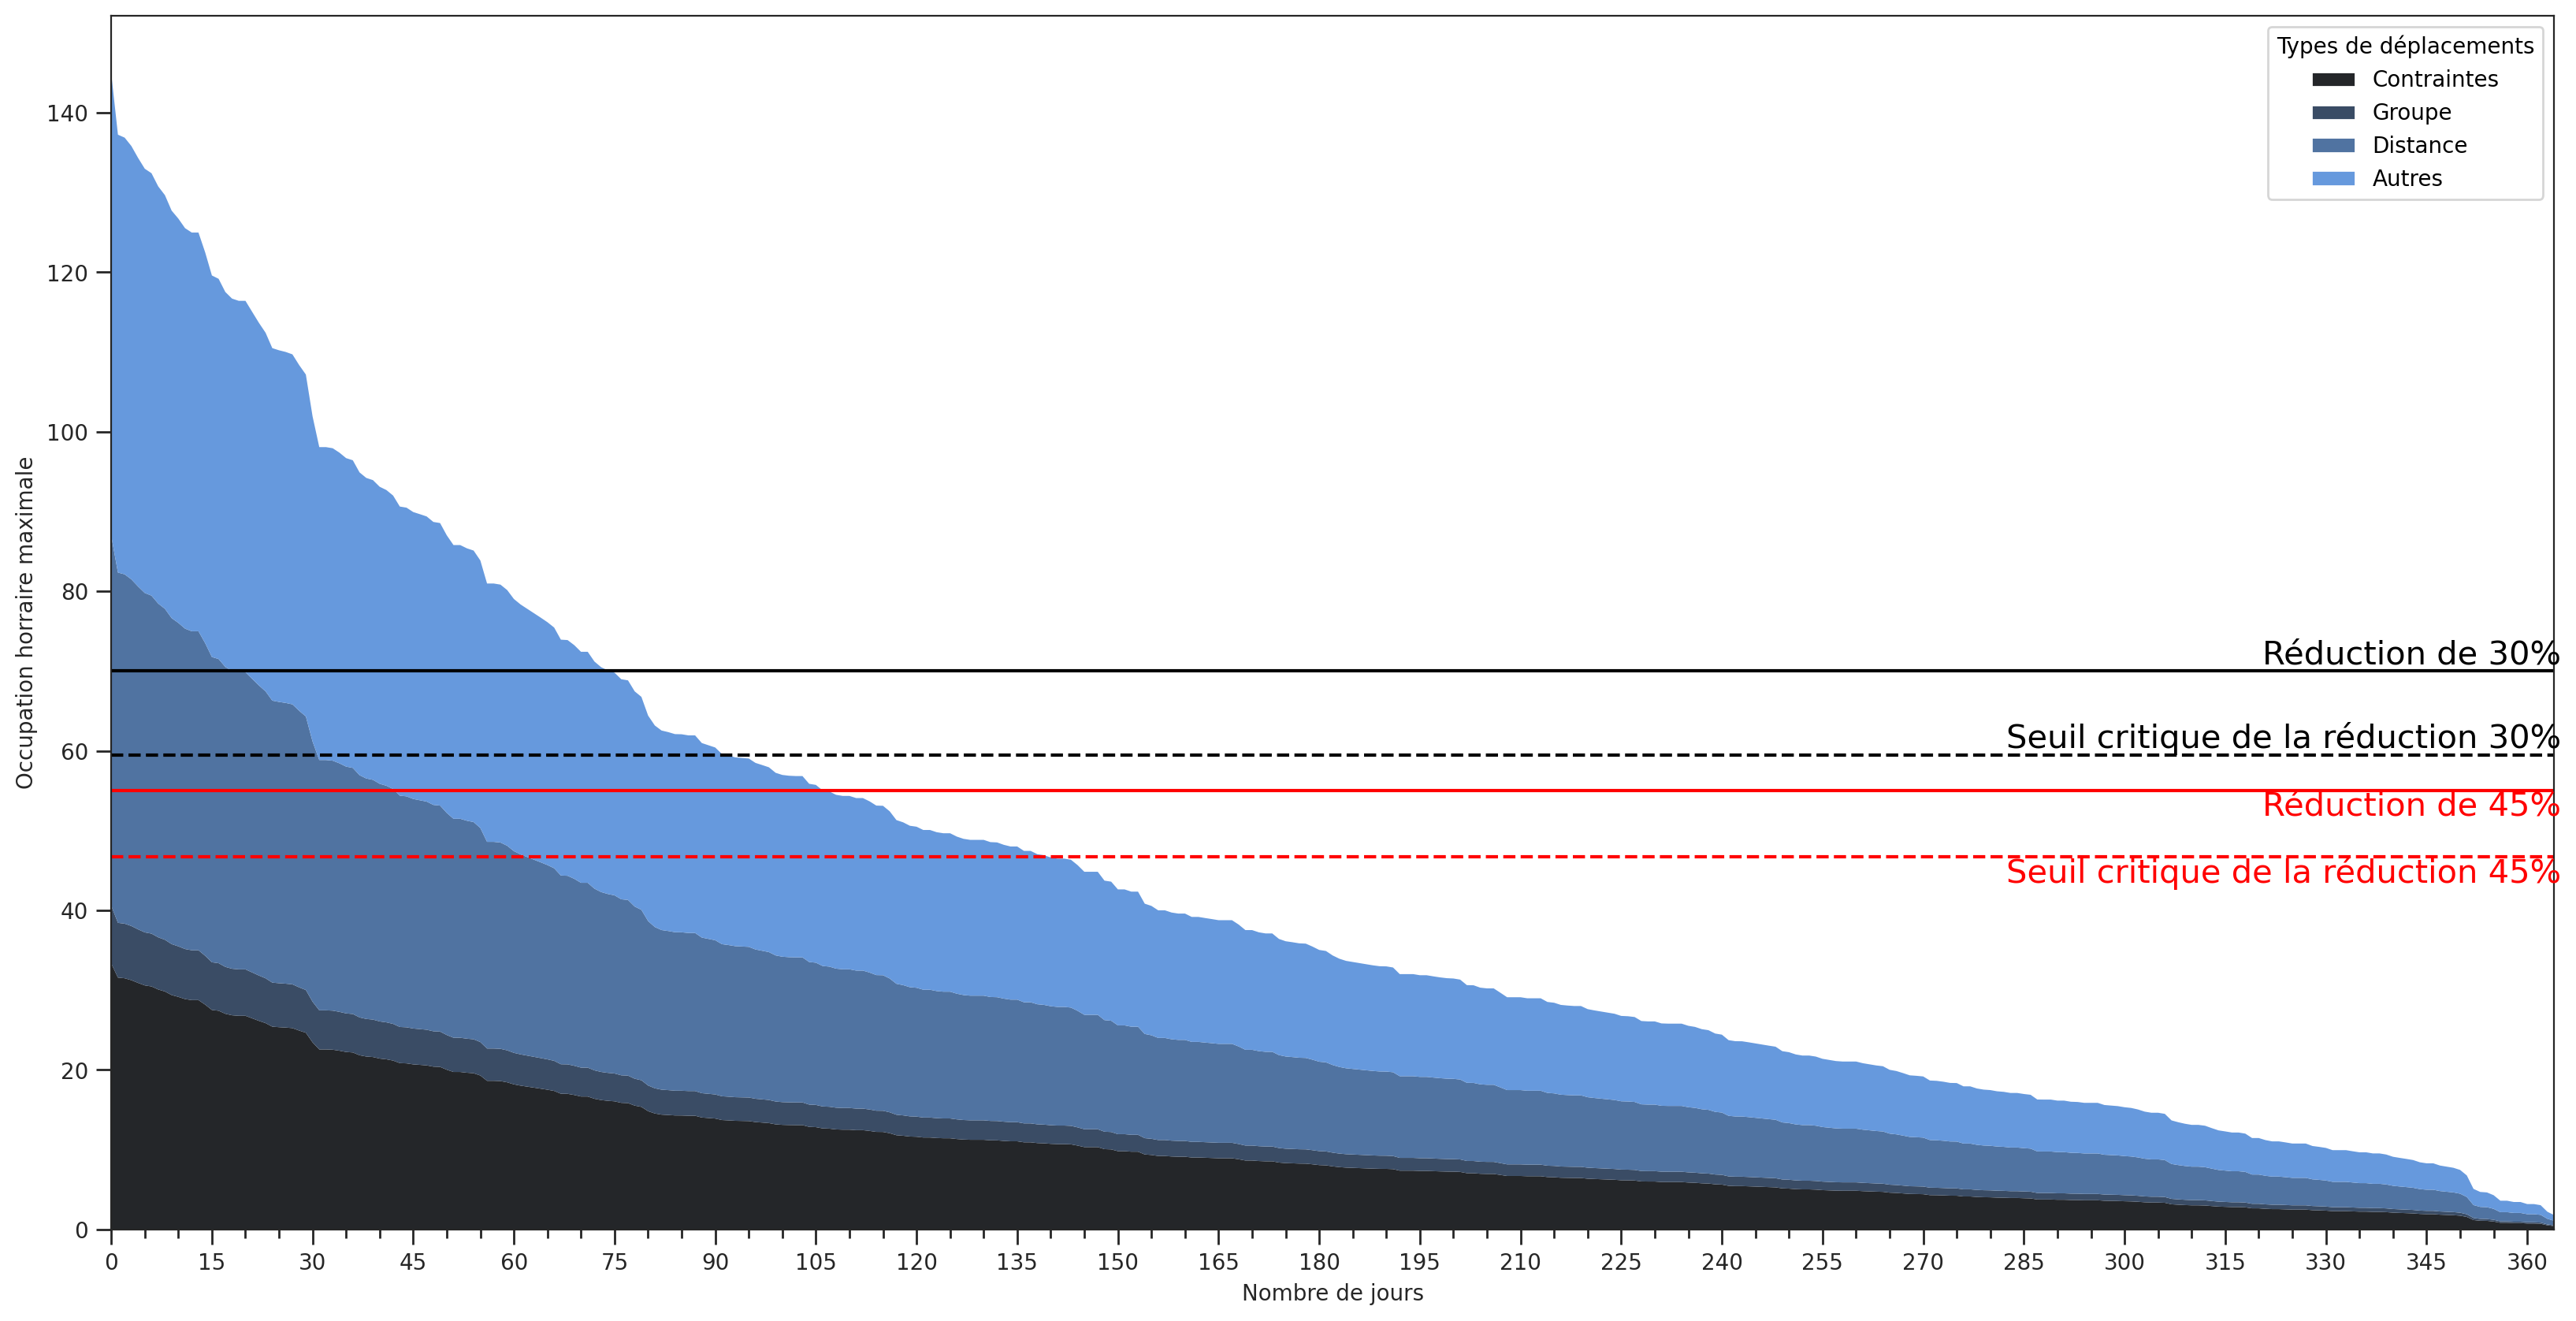

In [125]:
f, ax = plot_stacked_charge_graphs(charges=charges, groupnames=groupnames, x=data_contraintes.Ordre.unique(), legend_kwargs={'loc':'upper right'}, colormap=LAPIN_PALETTES['PROV_BLUES'](n_colors=len(groupnames)), ax=ax, figsize=(20,10), figdpi=200, return_fig=True)
# Réduction de 30%
plt.axhline(y=70, color='k', linestyle='-');
t = plt.text(365, 70, f'Réduction de 30%', fontsize=15, color='k', va='bottom', ha='right', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))
# 85% de 30%
plt.axhline(y=(70*0.85), color='k', linestyle='--');
t = plt.text(365, (70*0.85), f'Seuil critique de la réduction 30%', fontsize=15, color='k', va='bottom', ha='right', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))

# Réduction de 45%
plt.axhline(y=55, color='r', linestyle='-');
t = plt.text(365, 55, f'Réduction de 45%', fontsize=15, color='r', va='top', ha='right', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))
# 85% de 30%
plt.axhline(y=(55*0.85), color='r', linestyle='--');
t = plt.text(365, (55*0.85), f'Seuil critique de la réduction 45%', fontsize=15, color='r', va='top', ha='right', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True
)
# ticks
ax.xaxis.set_major_locator(MultipleLocator(15))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(5))

# margin
ax.margins(x=0)

ax.tick_params(which='both', width=1)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)

ax.set_xlabel('Nombre de jours')
ax.set_ylabel('Occupation horraire maximale');
ax.legend(title='Types de déplacements', loc='upper right')
f.savefig(f'./figs/analyse de dépassement/portrait du dépassement {ANNEE} - occup triée categorie.png')

Réduction des places de stationnement

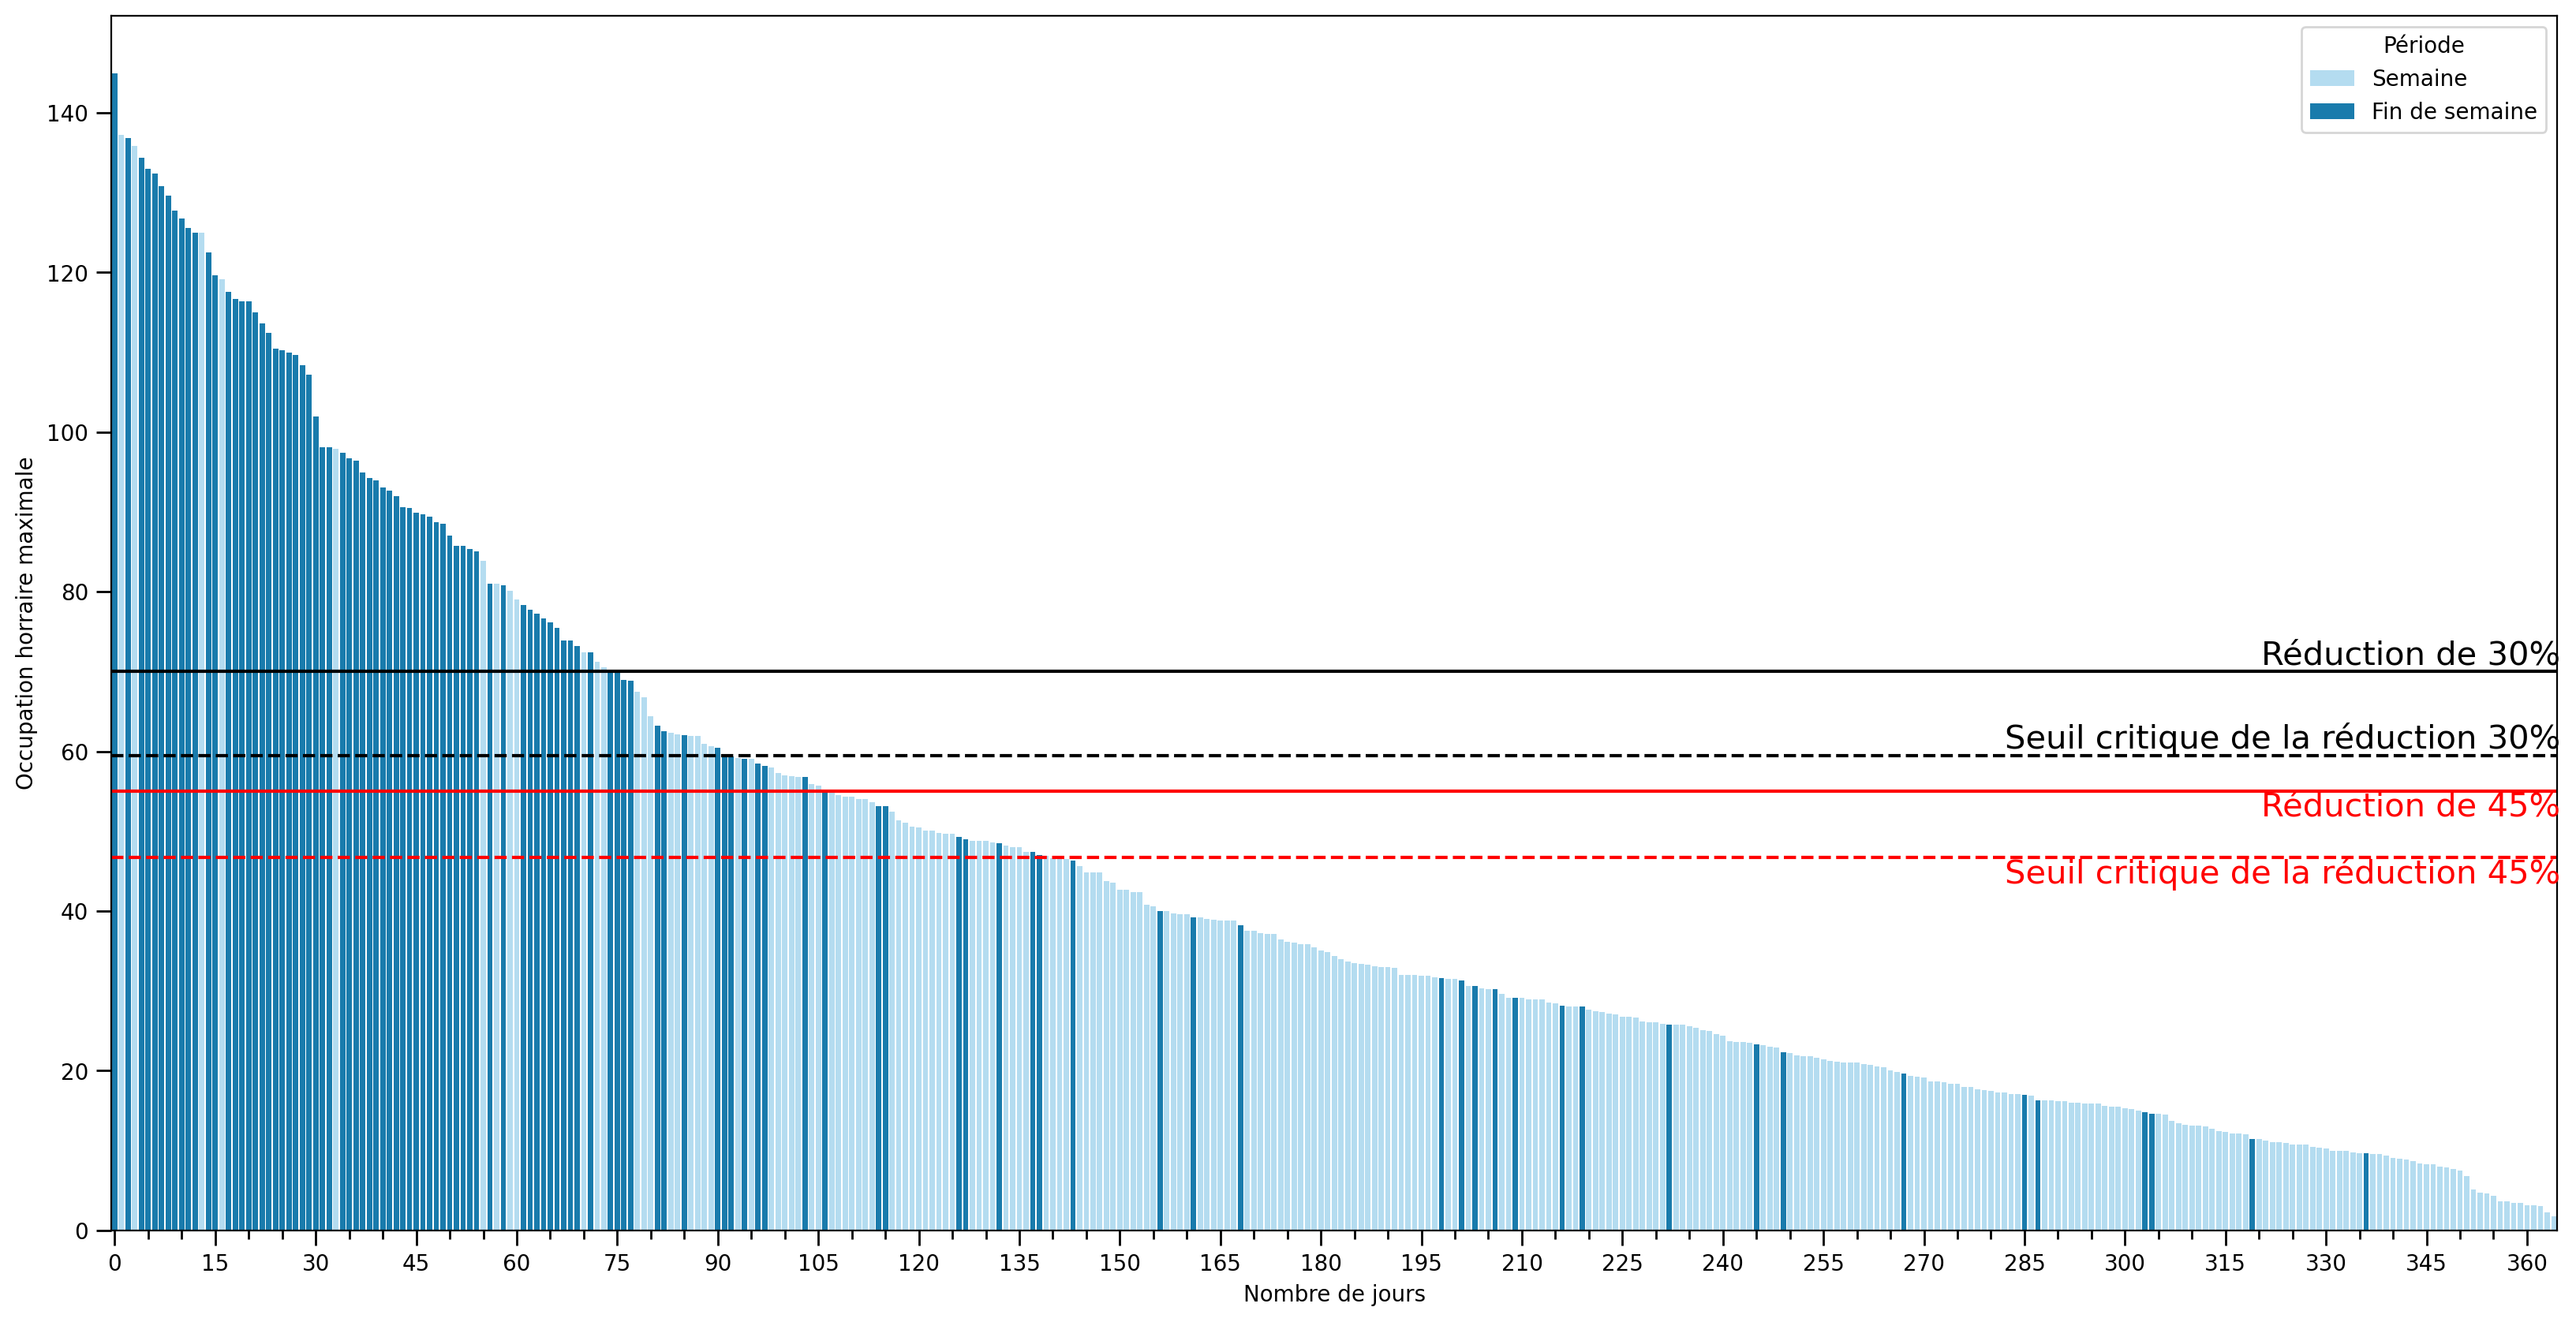

In [126]:
f, ax = plt.subplots(figsize=(20, 10), dpi=200)
sns.barplot(data=max_occup.sort_values('occup', ascending=False).reset_index(drop=True).reset_index(), x='index', y='occup', hue='Période', hue_order=['Semaine', 'Fin de semaine'], palette=palette, dodge=False)
# Réduction de 30%
plt.axhline(y=70, color='k', linestyle='-');
t = plt.text(365, 70, f'Réduction de 30%', fontsize=15, color='k', va='bottom', ha='right', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))
# 85% de 30%
plt.axhline(y=(70*0.85), color='k', linestyle='--');
t = plt.text(365, (70*0.85), f'Seuil critique de la réduction 30%', fontsize=15, color='k', va='bottom', ha='right', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))

# Réduction de 45%
plt.axhline(y=55, color='r', linestyle='-');
t = plt.text(365, 55, f'Réduction de 45%', fontsize=15, color='r', va='top', ha='right', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))
# 85% de 30%
plt.axhline(y=(55*0.85), color='r', linestyle='--');
t = plt.text(365, (55*0.85), f'Seuil critique de la réduction 45%', fontsize=15, color='r', va='top', ha='right', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))

# ticks
ax.xaxis.set_major_locator(MultipleLocator(15))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(5))

ax.tick_params(which='both', width=1)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)

ax.set_xlabel('Nombre de jours')
ax.set_ylabel('Occupation horraire maximale');
ax.legend(title='Période', loc='upper right')
f.savefig(f'./figs/analyse de dépassement/portrait du dépassement {ANNEE} - reduction du stationnement.png')

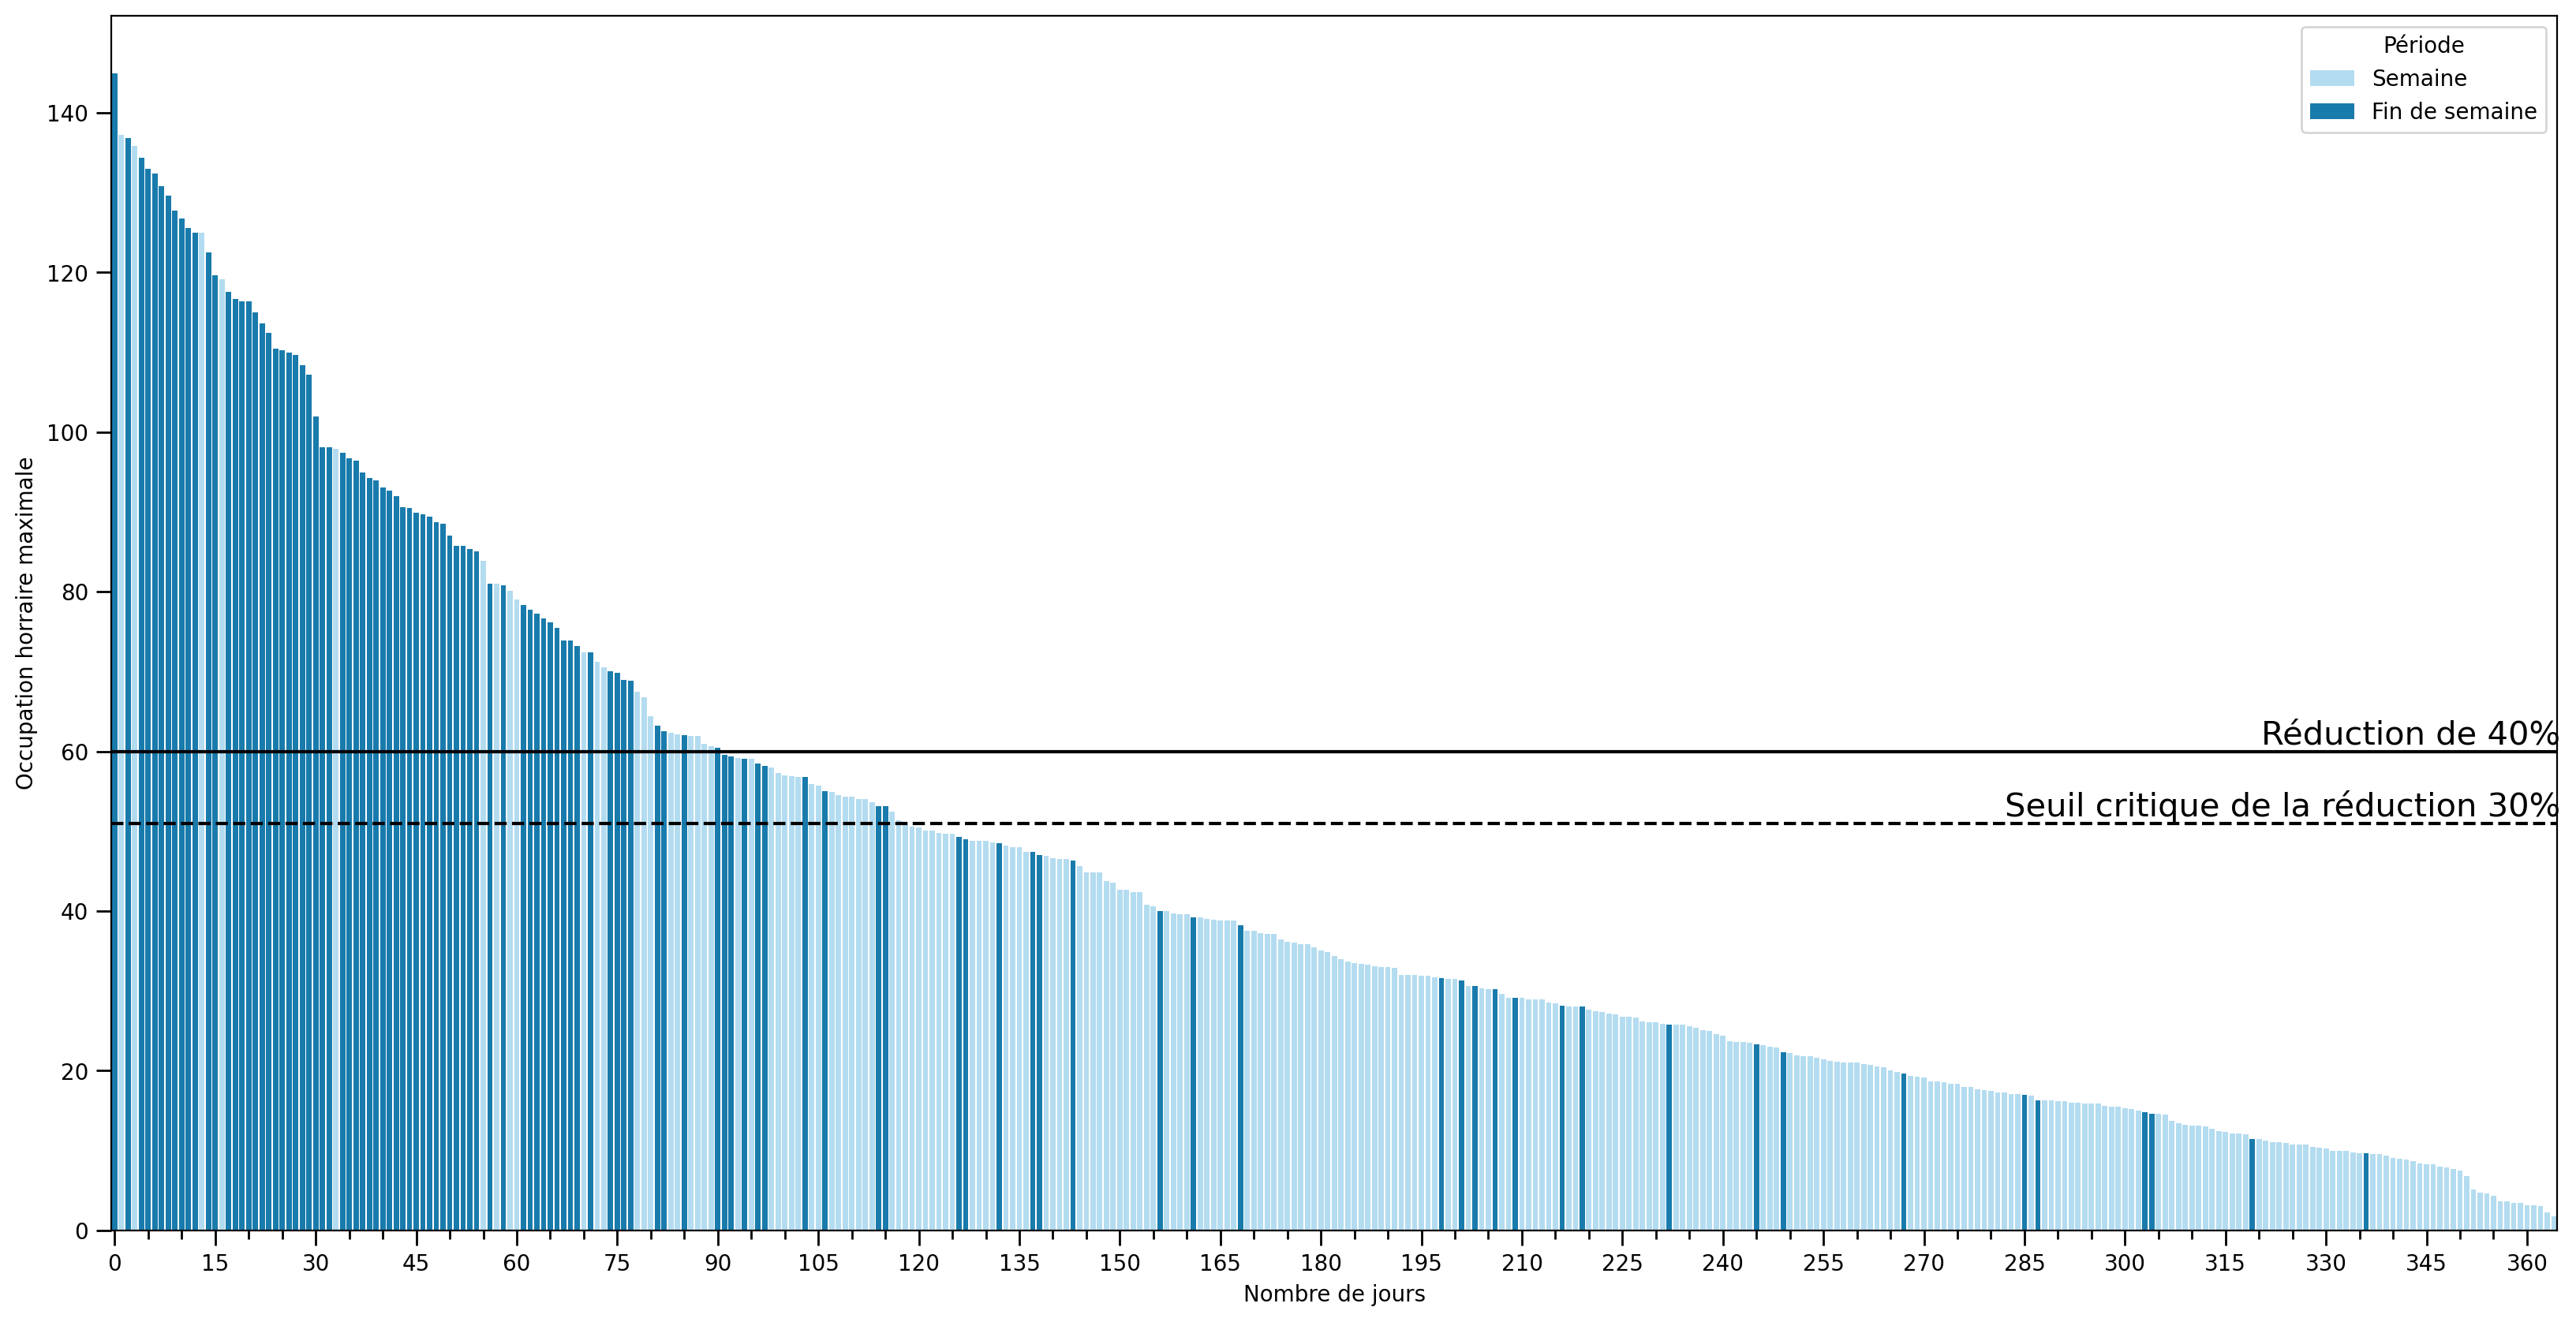

In [127]:
f, ax = plt.subplots(figsize=(20, 10), dpi=200)
sns.barplot(data=max_occup.sort_values('occup', ascending=False).reset_index(drop=True).reset_index(), x='index', y='occup', hue='Période', hue_order=['Semaine', 'Fin de semaine'], palette=palette, dodge=False)
# Réduction de 40%
plt.axhline(y=60, color='k', linestyle='-');
t = plt.text(365, 60, f'Réduction de 40%', fontsize=15, color='k', va='bottom', ha='right', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))
# 85% de 30%
plt.axhline(y=(60*0.85), color='k', linestyle='--');
t = plt.text(365, (60*0.85), f'Seuil critique de la réduction 30%', fontsize=15, color='k', va='bottom', ha='right', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))

# ticks
ax.xaxis.set_major_locator(MultipleLocator(15))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(5))

ax.tick_params(which='both', width=1)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)

ax.set_xlabel('Nombre de jours')
ax.set_ylabel('Occupation horraire maximale');
ax.legend(title='Période', loc='upper right')
f.savefig(f'./figs/analyse de dépassement/portrait du dépassement {ANNEE} - reduction du stat 40%.png')

Nombre de véhicules

In [132]:
import datetime

#total_veh = generated_trans.groupby('date')[['occupied_space']].sum().reset_index()
#total_veh['day_of_year'] = total_veh.date.dt.day_of_year
#total_veh['Période'] = ['Fin de semaine' if x in [5,6] else 'Semaine' for x in total_veh.date.dt.day_of_week]
#mean_tot = total_veh.occupied_space.describe().loc['mean']

filtered_count = filtered_count.reset_index()
filtered_count['datetime'] = list(map(datetime.datetime, filtered_count.year, filtered_count.month, filtered_count.day))
filtered_count['Période'] = ['Fin de semaine' if x.day_of_week in [5,6] else 'Semaine' for x in filtered_count.datetime]
filtered_count['day_of_year'] = filtered_count.datetime.dt.day_of_year
total_veh = filtered_count.groupby(['datetime', 'day_of_year', 'Période'])[['transactions_count_corrected']].sum().reset_index()
mean_tot = total_veh.transactions_count_corrected.mean()

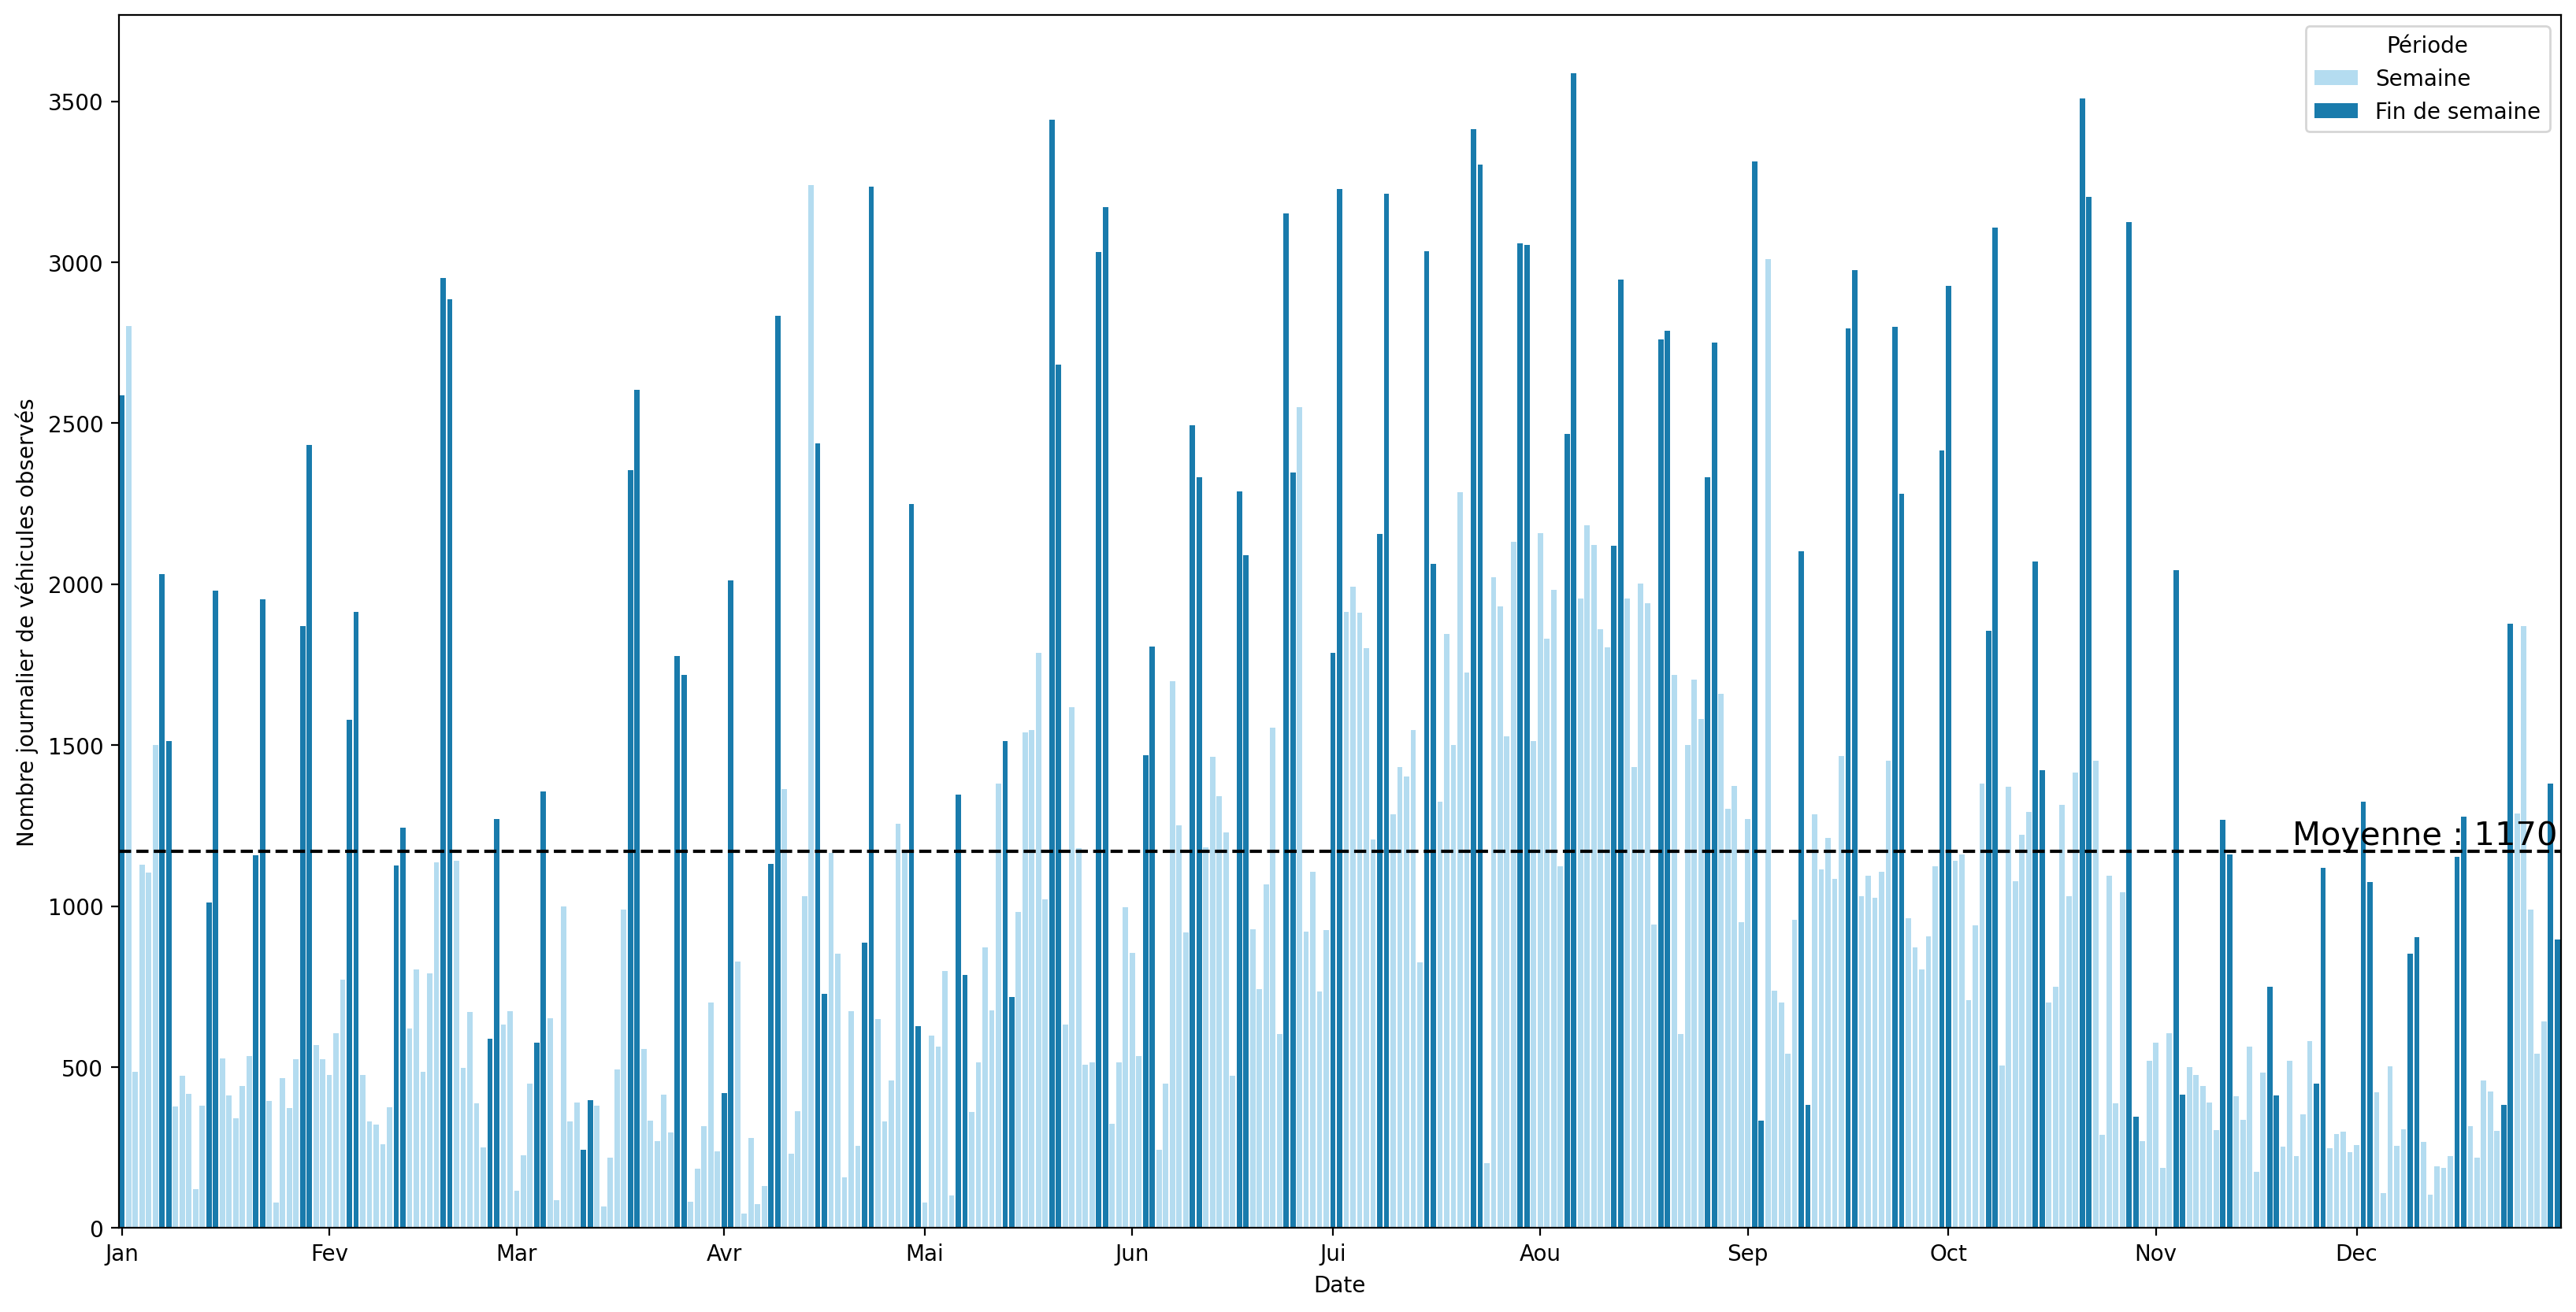

In [133]:
f, ax = plt.subplots(figsize=(20, 10), dpi=200)
sns.barplot(data=total_veh, x='day_of_year', y='transactions_count_corrected', hue='Période', hue_order=['Semaine', 'Fin de semaine'], palette=palette, dodge=False)
# Mean
plt.axhline(y=mean_tot, color='k', linestyle='--');
t = plt.text(364, mean_tot, f'Moyenne : {int(mean_tot)}', fontsize=15, va='bottom', ha='right', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))

ax.set_xticks(np.argwhere(months_label != '').ravel())
ax.set_xticklabels(['Jan', 'Fev', 'Mar', 'Avr', 'Mai', 'Jun', 'Jui', 'Aou', 'Sep', 'Oct', 'Nov', 'Dec']);
ax.set_xlabel('Date');
ax.set_ylabel('Nombre journalier de véhicules observés');
ax.legend(title='Période', loc='upper right')
f.savefig(f'./figs/analyse de dépassement/portrait du dépassement {ANNEE} - nombre de véhicules.png')

Journée type de dépassement

In [134]:
problematic_days = max_occup[max_occup.occup >= 85].date.values
problematic_days = generated_trans[generated_trans.date.isin(problematic_days)].copy()
problematic_days['Période'] = ['Fin de semaine' if x in [5,6] else 'Semaine' for x in problematic_days.date.dt.day_of_week]

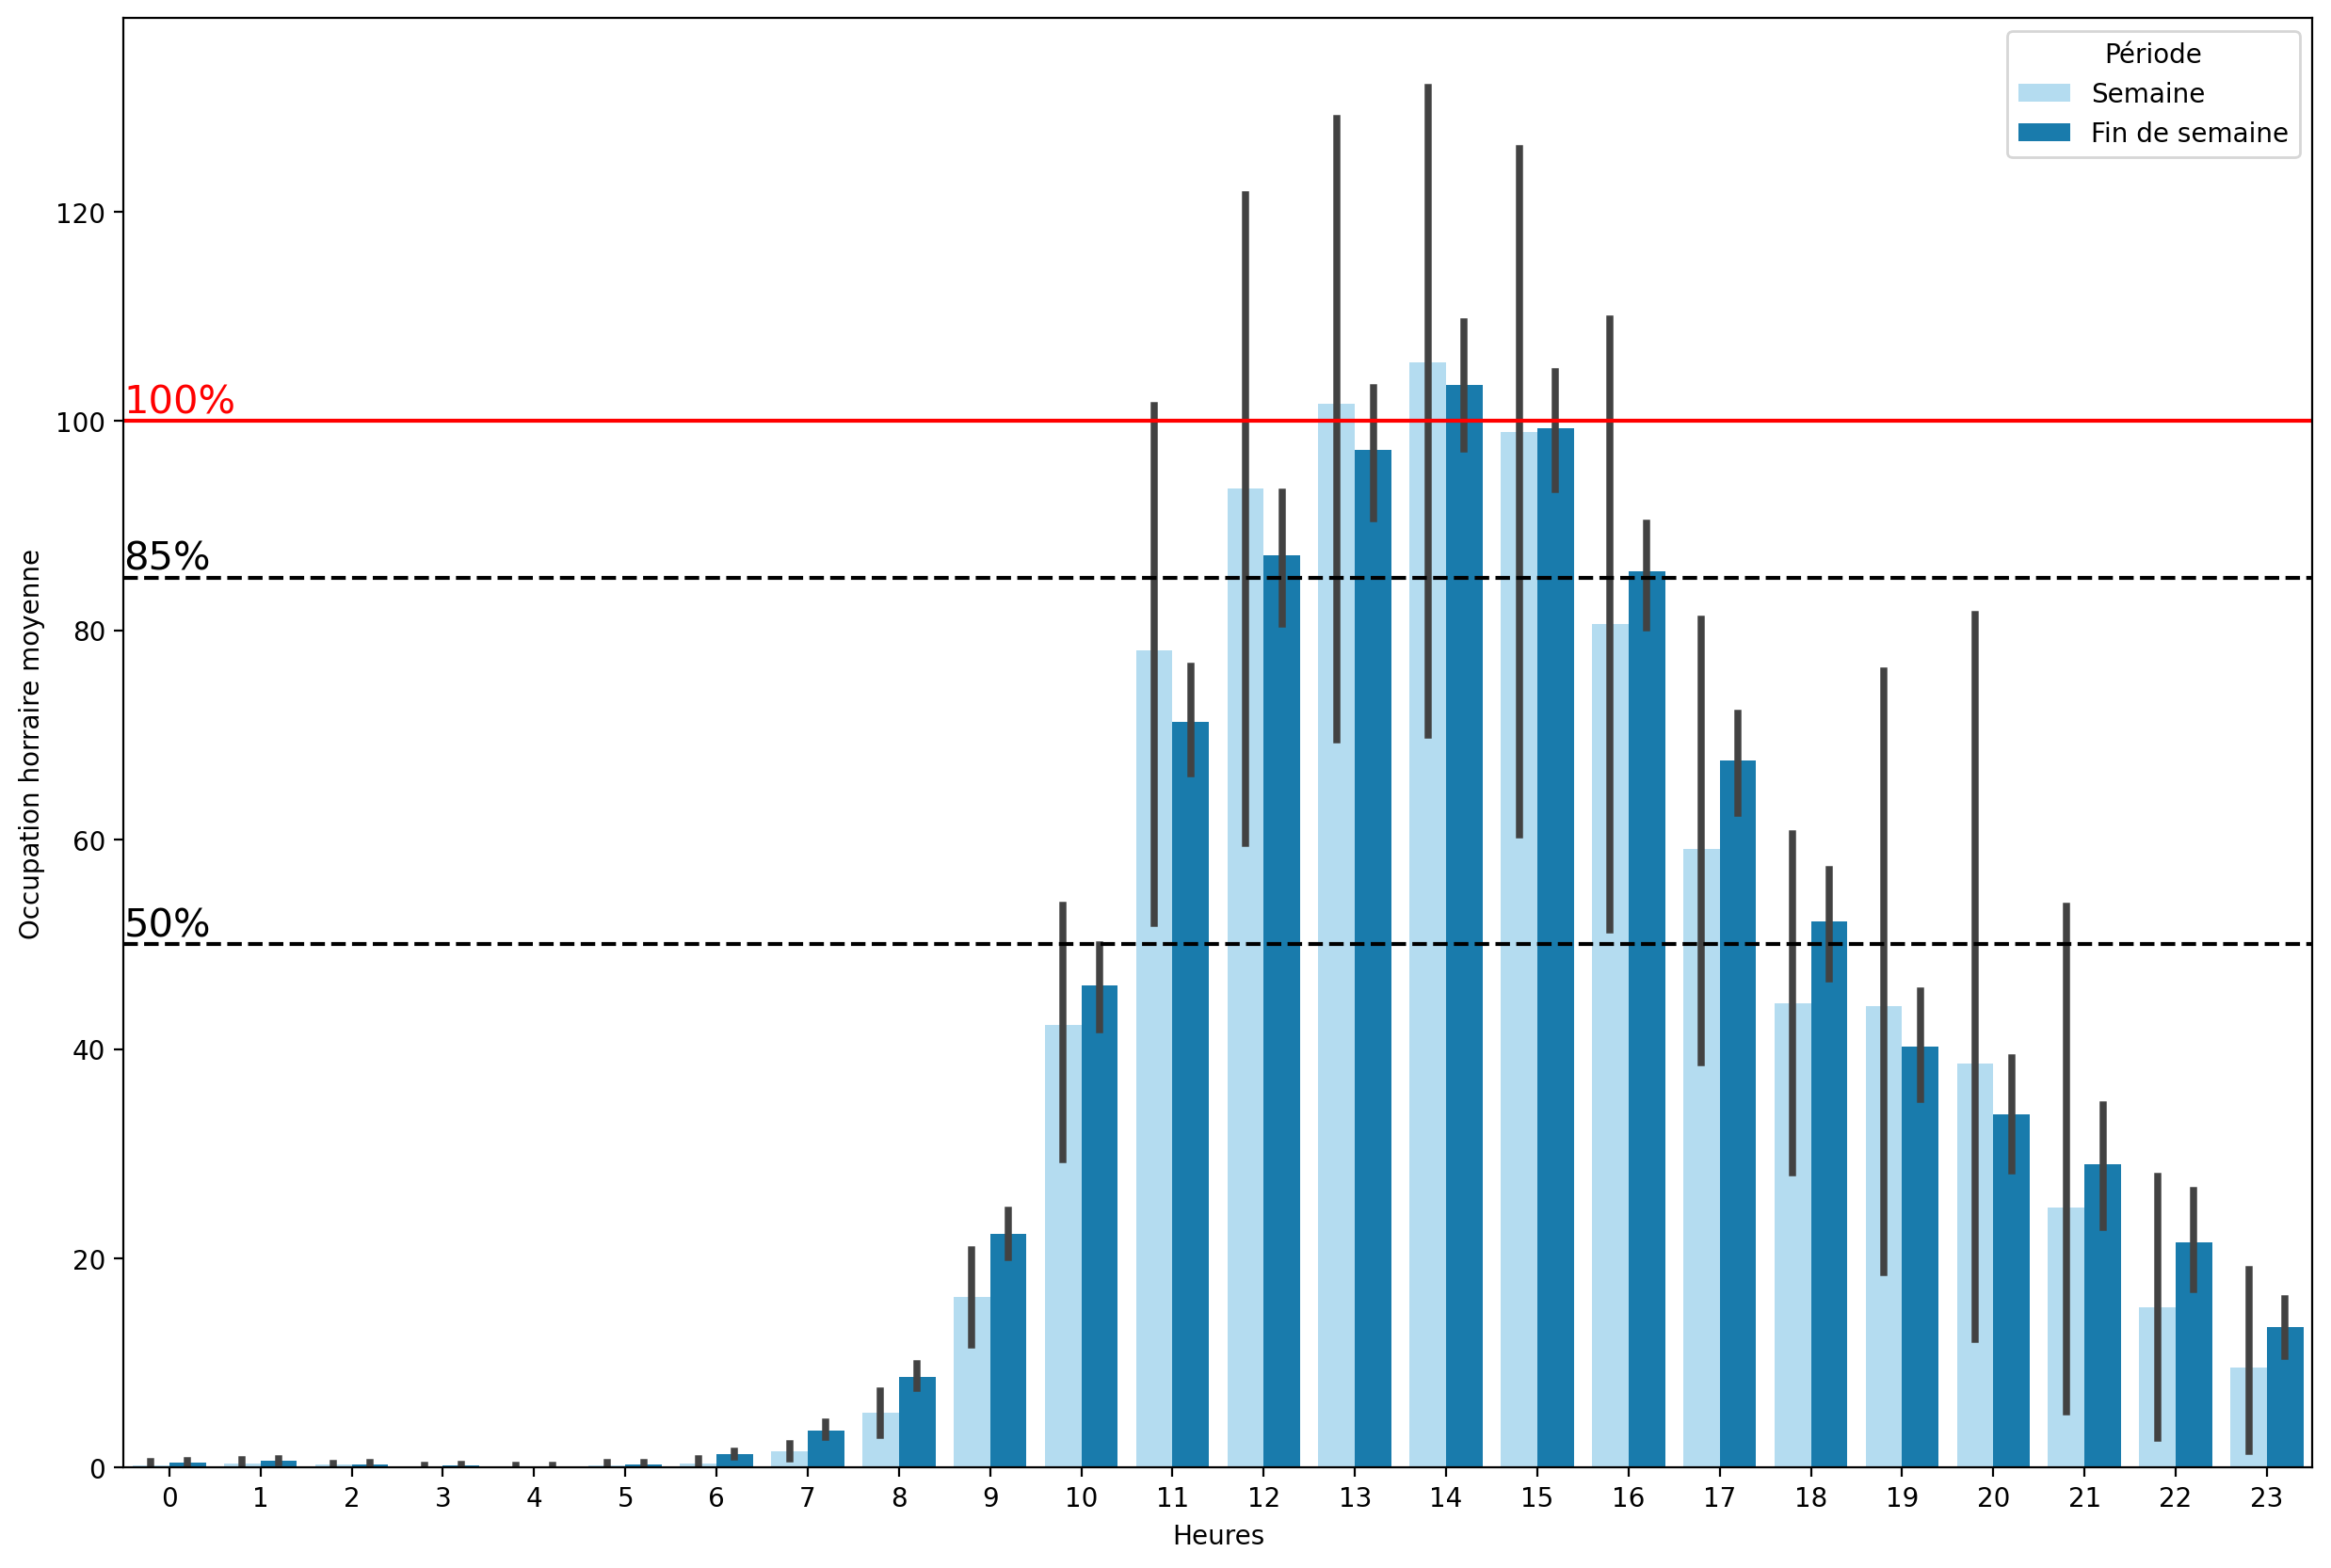

In [135]:
f, ax = plt.subplots(figsize=(15, 10), dpi=200)
sns.barplot(data=problematic_days, x='hour', y='occup', hue='Période', hue_order=['Semaine', 'Fin de semaine'], palette=palette, estimator=np.mean,  ax=ax)

# 100%
plt.axhline(y=100, color='r', linestyle='-');
t = plt.text(-0.5, 100, f'100%', fontsize=15, color='r', va='bottom', ha='left', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))
# 85%
plt.axhline(y=85, color='k', linestyle='--');
t = plt.text(-0.5, 85, f'85%', fontsize=15, color='k', va='bottom', ha='left', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))
# 50%
plt.axhline(y=50, color='k', linestyle='--');
t = plt.text(-0.5, 50, f'50%', fontsize=15, color='k', va='bottom', ha='left', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))

# ticks
ax.set_xlabel('Heures');
ax.set_ylabel('Occupation horraire moyenne');
ax.legend(title='Période', loc='upper right');
f.savefig(f'./figs/analyse de dépassement/portrait du dépassement {ANNEE} - journée.png')

Journée moyenne estivale

In [136]:
estivals_days = generated_trans[(generated_trans.date.dt.month >= 6) & (generated_trans.date.dt.month < 10)].copy()
estivals_days['Période'] = ['Fin de semaine' if x in [5,6] else 'Semaine' for x in estivals_days.date.dt.day_of_week]

In [144]:
estivals_days.columns

Index(['year', 'month', 'day', 'hour', 'occupied_space', 'date', 'capa',
       'occup', 'Période'],
      dtype='object')

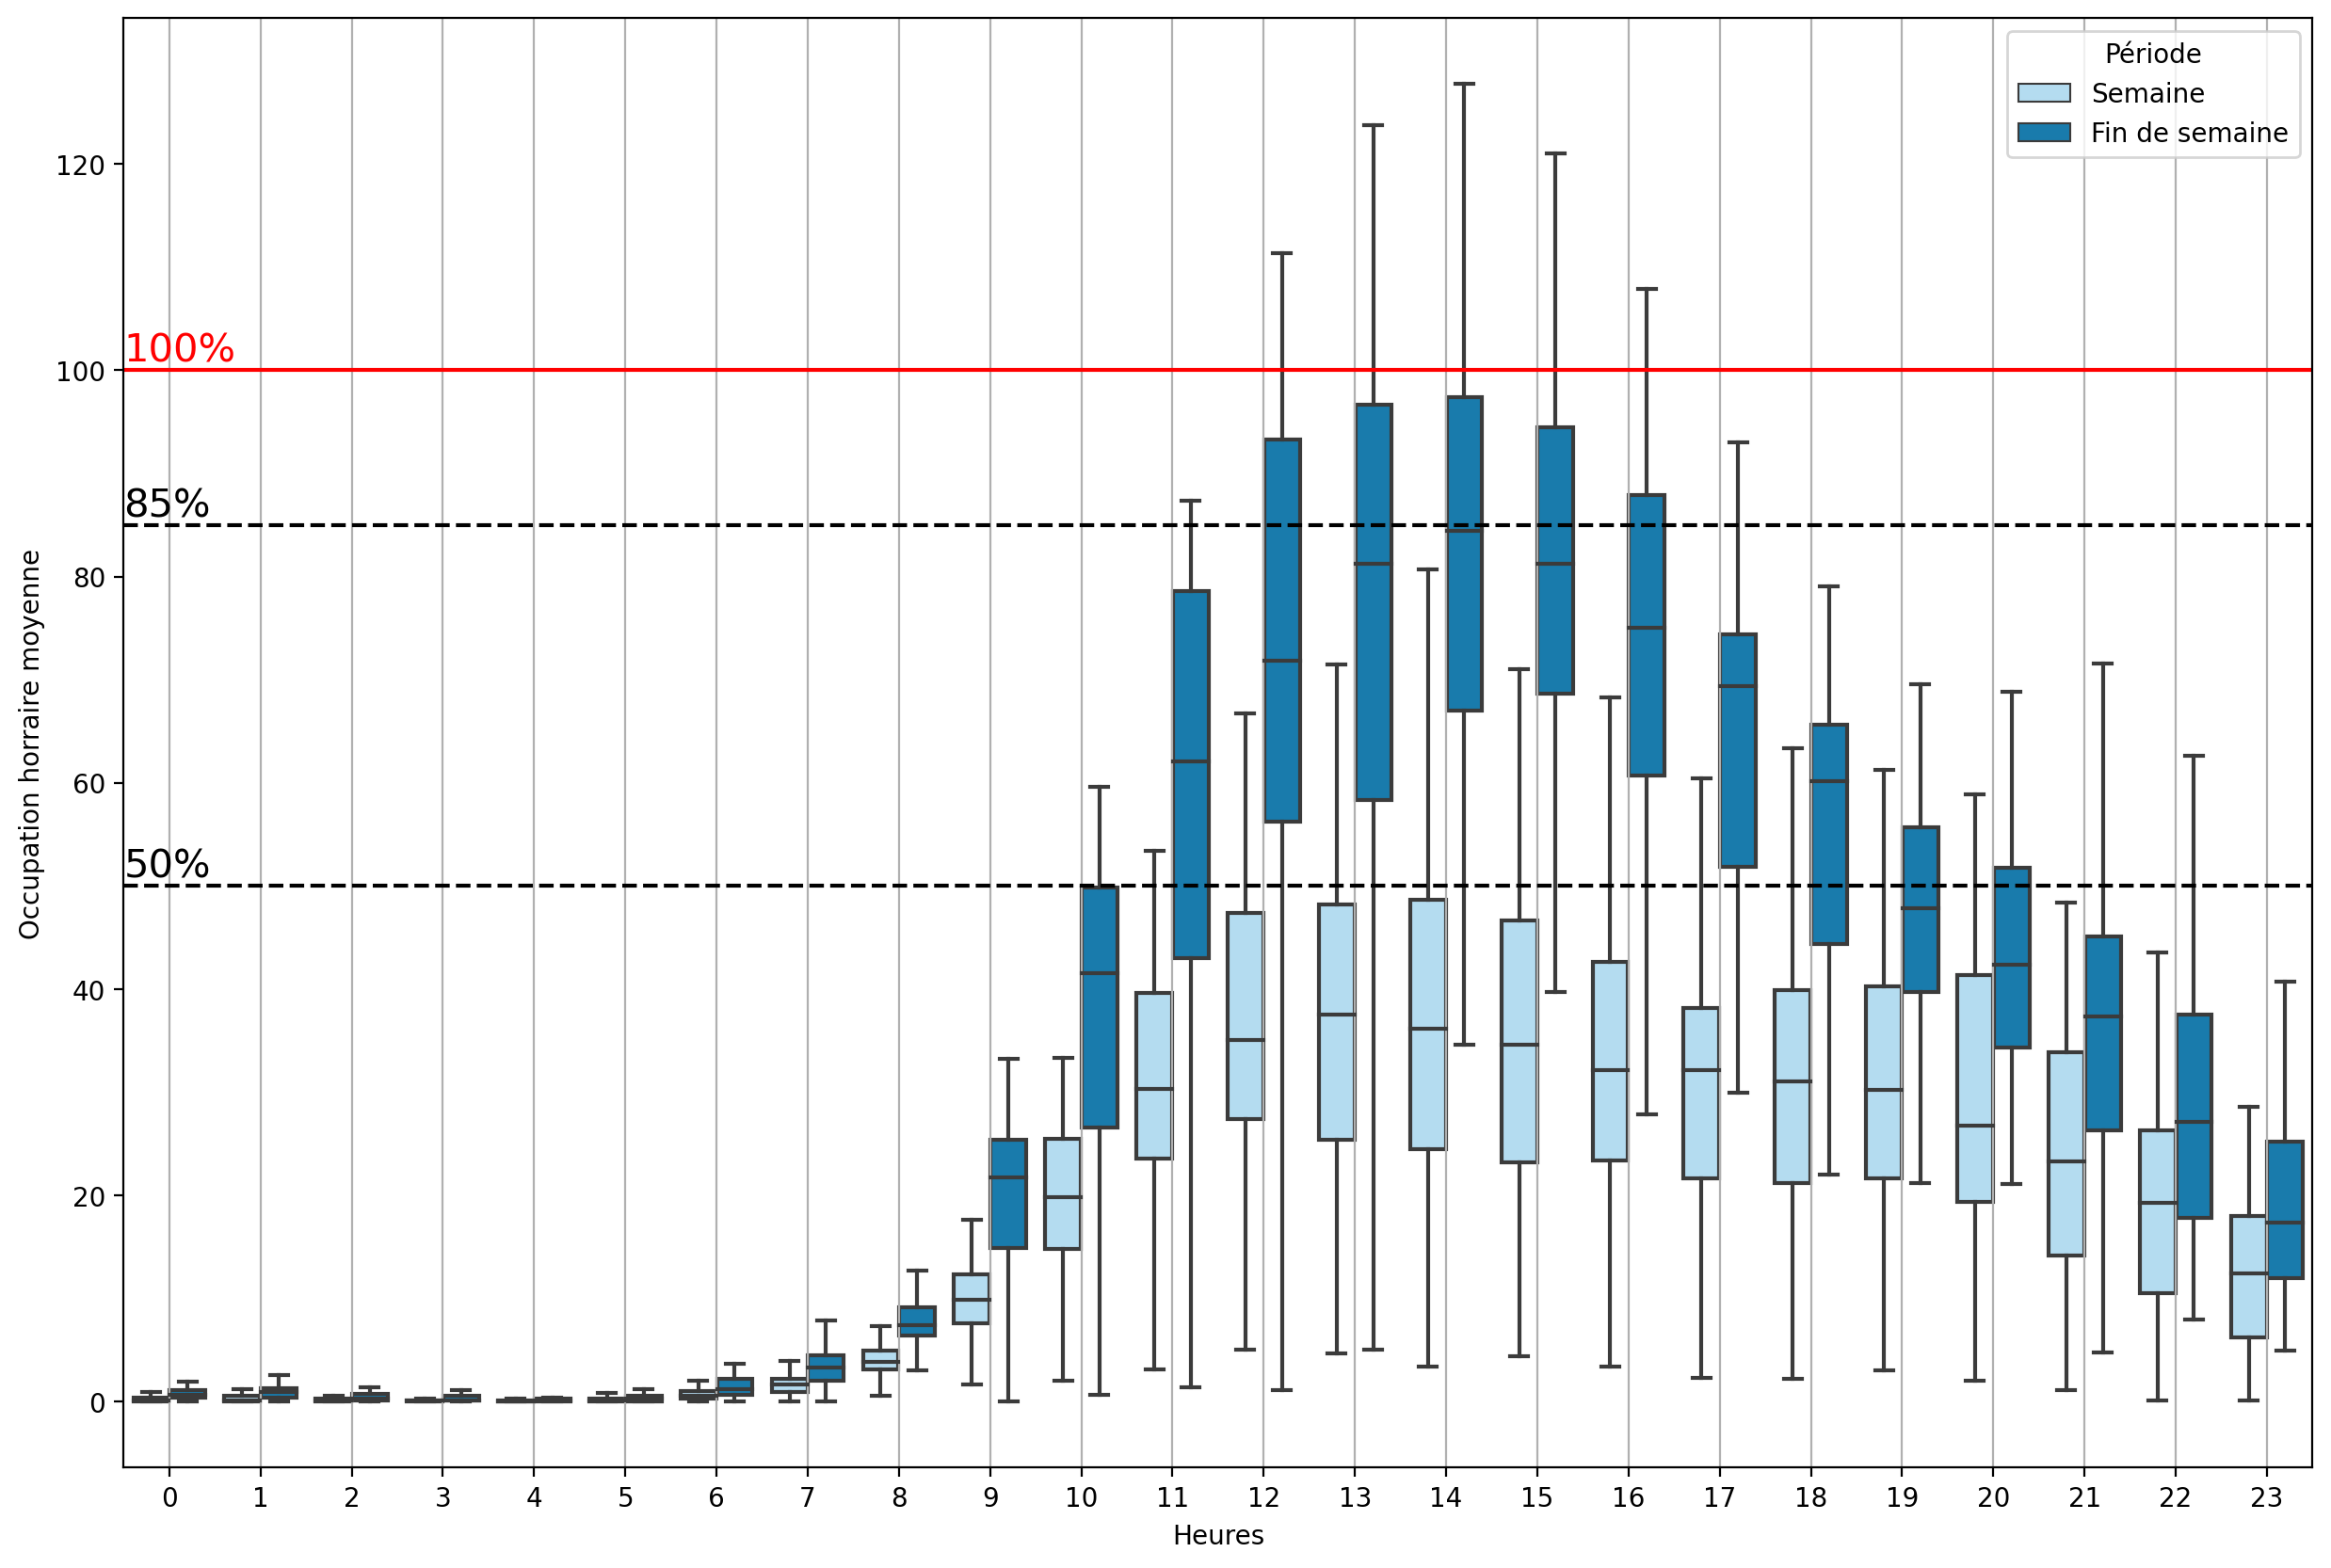

In [156]:
f, ax = plt.subplots(figsize=(15, 10), dpi=200)
sns.boxplot(data=estivals_days, x='hour', y='occup', hue='Période', palette=palette, showfliers=False, ax=ax)

# 100%
plt.axhline(y=100, color='r', linestyle='-');
t = plt.text(-0.5, 100, f'100%', fontsize=15, color='r', va='bottom', ha='left', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))
# 85%
plt.axhline(y=85, color='k', linestyle='--');
t = plt.text(-0.5, 85, f'85%', fontsize=15, color='k', va='bottom', ha='left', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))
# 50%
plt.axhline(y=50, color='k', linestyle='--');
t = plt.text(-0.5, 50, f'50%', fontsize=15, color='k', va='bottom', ha='left', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))

ax.set_xlabel('Heures');
ax.set_ylabel('Occupation horraire moyenne');
ax.legend(title='Période', loc='upper right');
ax.xaxis.grid(True) # vertical lines

f.savefig(f'./figs/analyse de dépassement/portrait du dépassement {ANNEE} boxplot - journée été.png')

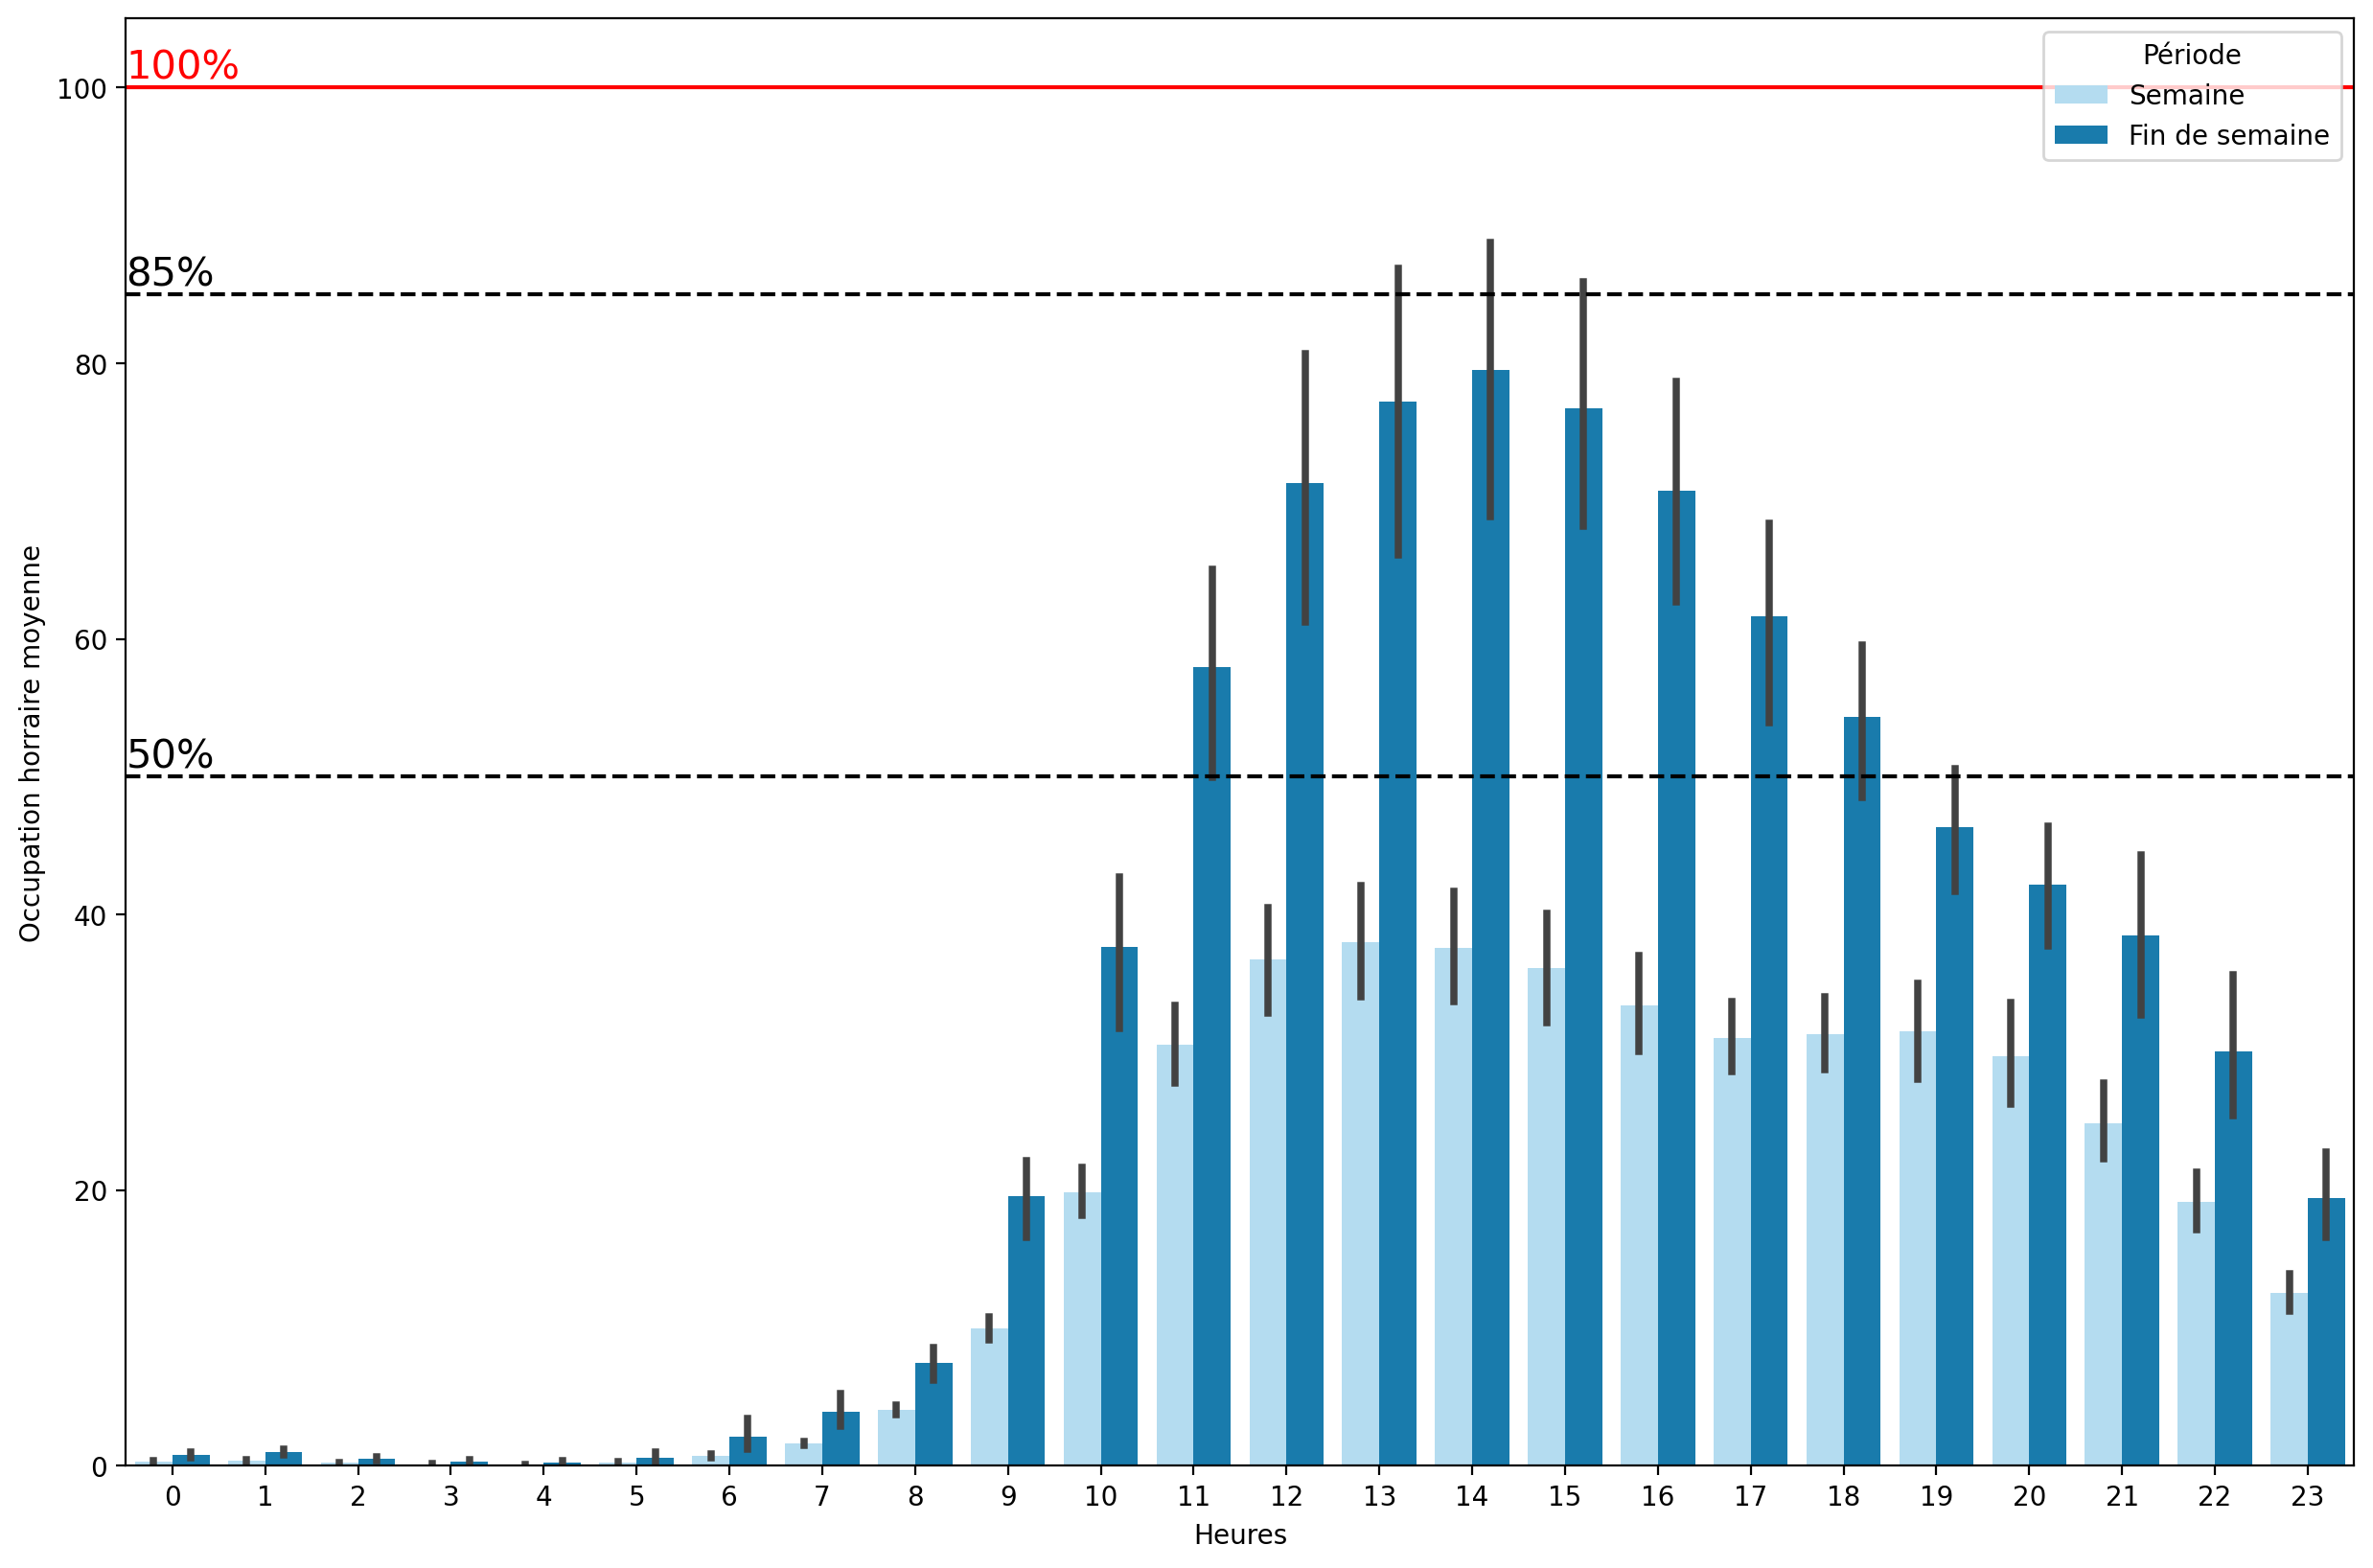

In [137]:
f, ax = plt.subplots(figsize=(15, 10), dpi=200)
sns.barplot(data=estivals_days, x='hour', y='occup', hue='Période', hue_order=['Semaine', 'Fin de semaine'], palette=palette, estimator=np.mean,  ax=ax)

# 100%
plt.axhline(y=100, color='r', linestyle='-');
t = plt.text(-0.5, 100, f'100%', fontsize=15, color='r', va='bottom', ha='left', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))
# 85%
plt.axhline(y=85, color='k', linestyle='--');
t = plt.text(-0.5, 85, f'85%', fontsize=15, color='k', va='bottom', ha='left', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))
# 50%
plt.axhline(y=50, color='k', linestyle='--');
t = plt.text(-0.5, 50, f'50%', fontsize=15, color='k', va='bottom', ha='left', backgroundcolor='w')
t.set_bbox(dict(facecolor='w', alpha=0, edgecolor='w'))

# ticks
ax.set_xlabel('Heures');
ax.set_ylabel('Occupation horraire moyenne');
ax.legend(title='Période', loc='upper right');
f.savefig(f'./figs/analyse de dépassement/portrait du dépassement {ANNEE} - journée été.png')